Introduction to Tensors

https://www.tensorflow.org/guide/tensor

Introduction to Variables

https://www.tensorflow.org/guide/variable

Introduction to gradients and automatic differentiation

https://www.tensorflow.org/guide/autodiff


In [ ]:
# These are all the necessary imports
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers, losses
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from pandas import DataFrame as df
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
from matplotlib.ticker import MultipleLocator
import time
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
import math
import time


# Built-in Functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(16,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap,vmin=0,vmax=100)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
def confmat_percent(confmat):
  conf_percent = (confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis])*100
  conf_percent_df= pd.DataFrame(conf_percent)
  conf_percent_df.columns=['CL1','CL2','CL3']
  conf_percent_df.index= ['CL1','CL2','CL3']
  return conf_percent_df

def confmat_df(confmat):
  conf_df= pd.DataFrame(confmat)
  conf_df.columns=['CL1','CL2','CL3']
  conf_df.index= ['CL1','CL2','CL3']
  conf_df['Sum']= confmat.sum(axis=1)
  return conf_df

In [ ]:
def confidence_interval(cv,confmat):
  cv= cv
  Ntest_CL1= confmat.loc['CL1']['Sum']    #sum of test CL1 values
  Ntest_CL2= confmat.loc['CL2']['Sum']    #sum of test CL2 values
  Ntest_CL3= confmat.loc['CL3']['Sum']    #sum of test CL3 values
  ptest_CL1= (confmat.loc['CL1']['CL1'])/Ntest_CL1
  ptest_CL2= (confmat.loc['CL2']['CL2'])/Ntest_CL2
  ptest_CL3= (confmat.loc['CL3']['CL3'])/Ntest_CL3

  #CI for CL1 
  sigma_test_CL1= math.sqrt(ptest_CL1*(1-ptest_CL1)/Ntest_CL1) 
  lower_test_CL1= (ptest_CL1-(cv*sigma_test_CL1))*100
  upper_test_CL1= (ptest_CL1 + (cv*sigma_test_CL1))*100
  #CI for CL2
  sigma_test_CL2= math.sqrt(ptest_CL2*(1-ptest_CL2)/Ntest_CL2) 
  lower_test_CL2= (ptest_CL2-(cv*sigma_test_CL2))*100
  upper_test_CL2= (ptest_CL2 + (cv*sigma_test_CL2))*100

  #CI for CL3
  sigma_test_CL3= math.sqrt(ptest_CL3*(1-ptest_CL3)/Ntest_CL3) 
  lower_test_CL3= (ptest_CL3-(cv*sigma_test_CL3))*100
  upper_test_CL3= (ptest_CL3 + (cv*sigma_test_CL3))*100

  # Overall CI
  N1= confmat['Sum'].sum()
  diag_sum= np.trace(confmat)
  p1= diag_sum/N1
  sigma_p1= math.sqrt(p1*(1-p1)/N1)
  lower_limit= (p1-(cv*sigma_p1))*100
  upper_limit= (p1+(cv*sigma_p1))*100


  CI_data= {'Class':['CL1','CL2','CL3','Overall'],
            'Lower Limit':[lower_test_CL1, lower_test_CL2, lower_test_CL3, lower_limit],
            'Upper Limit': [upper_test_CL1, upper_test_CL2, upper_test_CL3, upper_limit]}

  CI_table= pd.DataFrame(CI_data, columns=['Class','Lower Limit','Upper Limit'])

  return(CI_table.round(2))

# Importing Data, handling, and Standardization

In [ ]:
# Connecting this colab doc to the shared drive - For use with Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reads in the font files
font1 = pd.read_csv('BITSTREAMVERA.csv')
font2 = pd.read_csv('CONSOLAS.csv')
font3 = pd.read_csv('ISOC.csv')

In [ ]:
# Drops the unecessary features of the font data sets.  Keeps only "font", "strength", "italic" and the pixel gray scales
keep = [0,3,4] + list(range(12,412))
font1 = font1.iloc[:,keep]
font2 = font2.iloc[:,keep]
font3 = font3.iloc[:,keep]

# Filters the fonts to keep only the non-bold and non-italic characters
font1 = font1[(font1['strength']==0.4) & (font1['italic']==0)]
font2 = font2[(font2['strength']==0.4) & (font2['italic']==0)]
font3 = font3[(font3['strength']==0.4) & (font3['italic']==0)]

In [ ]:
print(font1.shape)
print(font2.shape)
print(font3.shape)
print(font1)

(2296, 403)
(2285, 403)
(2361, 403)
               font  strength  italic  r0c0  ...  r19c16  r19c17  r19c18  r19c19
0     BITSTREAMVERA       0.4       0     1  ...       1       1       1       1
1     BITSTREAMVERA       0.4       0     1  ...      30       1       1       1
2     BITSTREAMVERA       0.4       0   106  ...       1       1       1       1
3     BITSTREAMVERA       0.4       0     1  ...       1       1       1       1
4     BITSTREAMVERA       0.4       0    43  ...       1       1       1       1
...             ...       ...     ...   ...  ...     ...     ...     ...     ...
2291  BITSTREAMVERA       0.4       0     1  ...       1       1       1       1
2292  BITSTREAMVERA       0.4       0     1  ...       1       1       1       1
2293  BITSTREAMVERA       0.4       0     1  ...       1       1       1       1
2294  BITSTREAMVERA       0.4       0     1  ...       1       1       1       1
2295  BITSTREAMVERA       0.4       0     1  ...     255     255     255 

In [ ]:
# Creates the X and Y portions of each font
keep2 = list(range(3,403))
font1_X = font1.iloc[:,keep2].to_numpy()
font2_X = font2.iloc[:,keep2].to_numpy()
font3_X = font3.iloc[:,keep2].to_numpy()
#font1_Y = np.array(['CL1']*font1_X.shape[0])
#font2_Y = np.array(['CL2']*font2_X.shape[0])
#font3_Y = np.array(['CL3']*font3_X.shape[0])
font1_Y = np.array([[1,0,0]]*font1_X.shape[0])
font2_Y = np.array([[0,1,0]]*font2_X.shape[0])
font3_Y = np.array([[0,0,1]]*font3_X.shape[0])

# Standardizing the input layer.  (output layer does not get standardized)
# X = np.stack((font1_X, font2_X, font3_X))
X = np.vstack((font1_X, font2_X, font3_X))
X_scaled = StandardScaler().fit_transform(X)

# Separating the inputs after rescaling
n1 = font1.shape[0]
n2 = font2.shape[0]
n3 = font3.shape[0]
font1_X_scaled = X_scaled[0:n1,:]
font2_X_scaled = X_scaled[n1:(n1+n2),:]
font3_X_scaled = X_scaled[(n1+n2):,:]

# # Creating the TRAIN and TEST sets for each font
font1_Ytrain,font1_Ytest,font1_Xtrain,font1_Xtest = train_test_split(font1_Y,font1_X_scaled, train_size=0.8, random_state= 77)
font2_Ytrain,font2_Ytest,font2_Xtrain,font2_Xtest = train_test_split(font2_Y,font2_X_scaled, train_size=0.8, random_state= 77)
font3_Ytrain,font3_Ytest,font3_Xtrain,font3_Xtest = train_test_split(font3_Y,font3_X_scaled, train_size=0.8, random_state= 77)

# # Creating the final TRAIN and TEST sets
Xtrain = np.vstack((font1_Xtrain, font2_Xtrain, font3_Xtrain))
Xtest = np.vstack((font1_Xtest, font2_Xtest, font3_Xtest))
Ytrain = np.concatenate((font1_Ytrain, font2_Ytrain, font3_Ytrain))
Ytest = np.concatenate((font1_Ytest, font2_Ytest, font3_Ytest))
print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)

(5552, 400)
(1390, 400)
(5552, 3)
(1390, 3)


In [ ]:
font1_Xtest.shape

(460, 400)

# Task 1- PCA analyses


## 1a- PCA for h0

In [ ]:
# Doing the PCA part
# np.corrcoef() gives the correlation between the rows, as opposed to R which does the columns.  Therefore, you need to transpose the argument matrix first.
CORR = np.corrcoef(X_scaled.T)

from numpy import linalg as LA
v, w = LA.eig(CORR)

# Confirming outputs
print(w.shape)
print(v.shape)

(400, 400)
(400,)


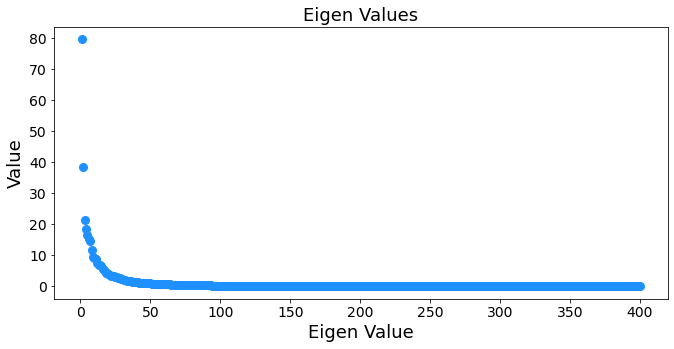

In [ ]:
# Showing the eigen values
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(11,5))
plt.plot(range(1,(len(v)+1)), v, 'bo', color='dodgerblue', markersize=8)
plt.xlabel('Eigen Value', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.title('Eigen Values', fontsize=18)
plt.show;

[19.9, 29.54, 34.86, 39.52, 43.67, 47.49, 51.13, 54.09, 56.44, 58.76, 60.95, 62.85, 64.59, 66.29, 67.91, 69.32, 70.63, 71.75, 72.8, 73.82, 74.78, 75.66, 76.51, 77.32, 78.12, 78.89, 79.6, 80.25, 80.87, 81.49, 82.04, 82.57, 83.05, 83.5, 83.92, 84.34, 84.73, 85.13, 85.49, 85.84, 86.19, 86.5, 86.81, 87.12, 87.41, 87.68, 87.94, 88.19, 88.44, 88.68, 88.92, 89.15, 89.37, 89.58, 89.78, 89.98, 90.17, 90.34, 90.52, 90.69, 90.85, 91.02, 91.18, 91.34, 91.49, 91.63, 91.78, 91.92, 92.06, 92.19, 92.33, 92.46, 92.58, 92.7, 92.82, 92.93, 93.05, 93.16, 93.26, 93.37, 93.47, 93.57, 93.67, 93.77, 93.86, 93.95, 94.04, 94.13, 94.22, 94.3, 94.38, 94.46, 94.54, 94.62, 94.7, 94.77, 94.84, 94.91, 94.98, 95.05, 95.12, 95.18, 95.24, 95.31, 95.37, 95.43, 95.49, 95.55, 95.61, 95.67, 95.72, 95.78, 95.83, 95.88, 95.94, 95.99, 96.04, 96.09, 96.14, 96.19, 96.23, 96.28, 96.33, 96.37, 96.42, 96.46, 96.5, 96.55, 96.59, 96.63, 96.67, 96.71, 96.75, 96.78, 96.82, 96.86, 96.89, 96.93, 96.97, 97.01, 97.04, 97.08, 97.11, 97.14, 

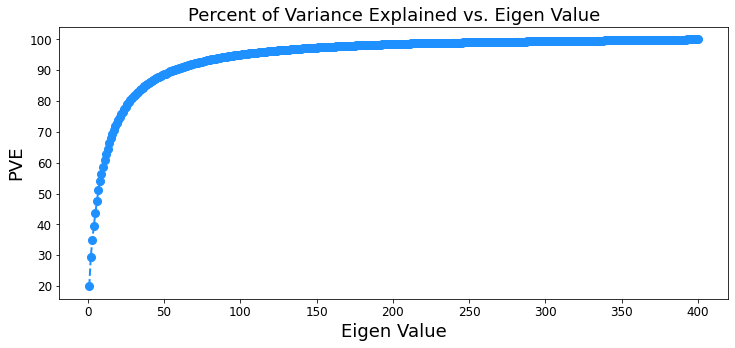

In [ ]:
PVE_vector = []
PVE_sum = 0
for i in v:
  PVE_sum += 100*i/sum(v)
  PVE_vector.append(round(PVE_sum, 2))

print(PVE_vector)

#It can be seen that 95% of Variance Explained is achieved with the first 99 eigen values.  Therefore h_min = 100
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(range(1,(len(PVE_vector)+1)), PVE_vector, color='dodgerblue', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Eigen Value', fontsize=18)
plt.ylabel('PVE', fontsize=18)
plt.title('Percent of Variance Explained vs. Eigen Value', fontsize=18)
plt.show;

box = np.asarray(PVE_vector)
h_min = np.where(box>95)[0][0] + 1
print(h_min)

(1390, 400)
(1390, 20, 20)


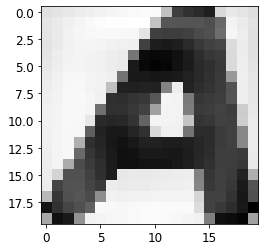

In [ ]:
# Showing an example of one of the characters

#(xx_train, yy_train), (xx_test, yy_test) = keras.datasets.mnist.load_data()

print(Xtest.shape)
#print(xx_test[3].shape)
box = Xtest.reshape(1390, 20, 20)
print(box.shape)
img = plt.imshow(box[7], cmap='Greys')
plt.show()

## 1b- PCA for h*

In [ ]:
# Doing PCA for each class to find h*
# Finding h1
font1_X_scaled = StandardScaler().fit_transform(font1_X)
font1_X_CORR = np.corrcoef(font1_X_scaled.T)
f1_v, f1_w = LA.eig(font1_X_CORR)

f1_PVE_vector = []
f1_PVE_sum = 0
for i in f1_v:
  f1_PVE_sum += 100*i/sum(f1_v)
  f1_PVE_vector.append(round(f1_PVE_sum, 2))

box1 = np.asarray(f1_PVE_vector)
h1 = np.where(box1>99)[0][0] + 1  # Don't we have to select 99% PVE for h*?

# Finding h2
font2_X_scaled = StandardScaler().fit_transform(font2_X)
font2_X_CORR = np.corrcoef(font2_X_scaled.T)
f2_v, f2_w = LA.eig(font2_X_CORR)

f2_PVE_vector = []
f2_PVE_sum = 0
for i in f2_v:
  f2_PVE_sum += 100*i/sum(f2_v)
  f2_PVE_vector.append(round(f2_PVE_sum, 2))

box2 = np.asarray(f2_PVE_vector)
h2 = np.where(box2>99)[0][0] + 1

# Finding h3
font3_X_scaled = StandardScaler().fit_transform(font3_X)
font3_X_CORR = np.corrcoef(font3_X_scaled.T)
f3_v, f3_w = LA.eig(font3_X_CORR)

f3_PVE_vector = []
f3_PVE_sum = 0
for i in f3_v:
  f3_PVE_sum += 100*i/sum(f3_v)
  f3_PVE_vector.append(round(f3_PVE_sum, 2))

box3 = np.asarray(f3_PVE_vector)
h3 = np.where(box3>99)[0][0] + 1

print("h1 is " + str(h1))
print("h2 is " + str(h2))
print("h3 is " + str(h3))
print("h* is " + str(h1+h2+h3))

h1 is 236
h2 is 201
h3 is 201
h* is 638



*   ho is 100.  
*   h* is 270 for 95% PVE.
*   h* is 638 for 99% PVE which satisifies h*>k

# Task 2,3, 4- Training and Monitoring, Confusion Matrices, and Compare performances

In [ ]:
p = Xtrain.shape[0]
h = 100
h_star = 638
my_epochs = 300
batch = int(p**0.5)
print(p)
print(batch)

5552
74


## MLP0 (for h0)

In [ ]:
# Functional API - More power full than the Sequential API. Using this kind of model, allows us to create sequential models as well as many other types of models.

inputs = keras.Input(shape=(400,)) # 400-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(h,activation="sigmoid")(inputs) # Giving this layer the inputs
outputs = layers.Dense(3, activation="softmax")(x1) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
model.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
dense_59 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_60 (Dense)             (None, 3)                 303       
Total params: 40,403
Trainable params: 40,403
Non-trainable params: 0
_________________________________________________________________


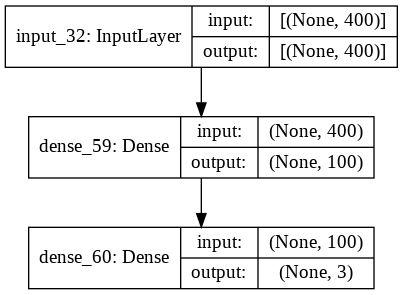

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
loss_fn = losses.CategoricalCrossentropy()
optimizer = optimizers.Adam() # LR 0.001 is the default

In [ ]:
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])

In [ ]:
start = time.process_time()
from tensorflow.keras import callbacks
checkpoint=callbacks.ModelCheckpoint(filepath='BestModel.h100',monitor='val_accuracy',save_best_only=True)
Monitor = model.fit(Xtrain, Ytrain, epochs=my_epochs, batch_size=batch, validation_data=(Xtest,Ytest), callbacks=[checkpoint])
model_h_time = (time.process_time() - start)
print(f"Time to run model: {model_h_time//60} minute {model_h_time%60} seconds")

Epoch 1/300
76/76 [==============================] - 1s 4ms/step - loss: 0.7666 - accuracy: 0.6523 - val_loss: 0.5694 - val_accuracy: 0.7799
INFO:tensorflow:Assets written to: BestModel.h100/assets
Epoch 2/300
76/76 [==============================] - 0s 3ms/step - loss: 0.5291 - accuracy: 0.7914 - val_loss: 0.5220 - val_accuracy: 0.7906
INFO:tensorflow:Assets written to: BestModel.h100/assets
Epoch 3/300
76/76 [==============================] - 0s 3ms/step - loss: 0.5011 - accuracy: 0.8097 - val_loss: 0.4862 - val_accuracy: 0.8079
INFO:tensorflow:Assets written to: BestModel.h100/assets
Epoch 4/300
76/76 [==============================] - 0s 3ms/step - loss: 0.4523 - accuracy: 0.8293 - val_loss: 0.4502 - val_accuracy: 0.8288
INFO:tensorflow:Assets written to: BestModel.h100/assets
Epoch 5/300
76/76 [==============================] - 0s 3ms/step - loss: 0.4247 - accuracy: 0.8484 - val_loss: 0.4224 - val_accuracy: 0.8367
INFO:tensorflow:Assets written to: BestModel.h100/assets
Epoch 6/30

In [ ]:
def plot_loss_and_acc(train_loss, val_loss, train_acc, val_acc):
  fig = plt.figure(figsize= (15,4))
  ax1 = fig.add_subplot(1,2,1)
  # Train & Test Loss plot
  plt.plot(range(1,(len(train_loss)+1)), train_loss, color='dodgerblue', linewidth=1, markersize=6) # Train Loss
  plt.plot(range(1,(len(train_loss)+1)), val_loss, color='red', linewidth=1, markersize=6) # Test Loss
  plt.xlabel('epoch #')
  plt.ylabel('Cross-Entropy Value')
  plt.title('C.E. Loss Plot')
  plt.legend(['Train Loss', 'Test Loss'])

  ax1 = fig.add_subplot(1,2,2)
  # Train & Test Accuracy plot
  plt.plot(range(1,(len(train_acc)+1)), train_acc, color='dodgerblue', linewidth=1, markersize=6) # Train Loss
  plt.plot(range(1,(len(train_acc)+1)), val_acc, color='red', linewidth=1, markersize=6) # Test Loss
  plt.xlabel('epoch #')
  plt.ylabel('Accuracy Value')
  plt.title('Accuracy Plot')
  plt.legend(['Train Acc', 'Test Acc']);

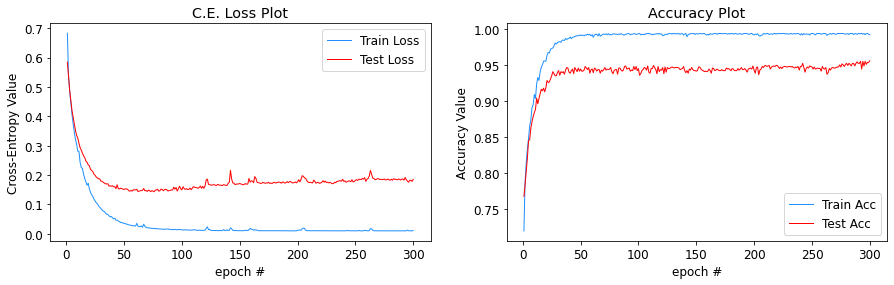

In [ ]:
plot_loss_and_acc(Monitor.history['loss'], Monitor.history['val_loss'],
                  Monitor.history['accuracy'], Monitor.history['val_accuracy'])

(Approximate numbers)

For MLP0,
*   Stabilization stabT= 50
*   Overfitting overT= 90 (really none)
*   Stopping Tstop= min(stabT, overT)= 50

### Confusion Matrix at Tstop (for h0)


In [ ]:
inputs = keras.Input(shape=(400,)) # 400-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(h,activation="sigmoid")(inputs) # Giving this layer the inputs
outputs = layers.Dense(3, activation="softmax")(x1) # Output layer with 3 classes
model = keras.Model(inputs=inputs,outputs=outputs)
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])

In [ ]:
my_epochs= 37     #Value From Tstop
checkpoint=callbacks.ModelCheckpoint(filepath='BestModel.h100_e50',monitor='val_accuracy',save_best_only=True)
model.fit(Xtrain, Ytrain, epochs=my_epochs, batch_size=batch, validation_data=(Xtest,Ytest), callbacks=[checkpoint])

Epoch 1/37
76/76 [==============================] - 1s 5ms/step - loss: 0.7023 - accuracy: 0.6969 - val_loss: 0.4965 - val_accuracy: 0.7928
INFO:tensorflow:Assets written to: BestModel.h100_e50/assets
Epoch 2/37
76/76 [==============================] - 0s 2ms/step - loss: 0.4357 - accuracy: 0.8398 - val_loss: 0.4086 - val_accuracy: 0.8345
INFO:tensorflow:Assets written to: BestModel.h100_e50/assets
Epoch 3/37
76/76 [==============================] - 0s 2ms/step - loss: 0.3628 - accuracy: 0.8721 - val_loss: 0.3624 - val_accuracy: 0.8604
INFO:tensorflow:Assets written to: BestModel.h100_e50/assets
Epoch 4/37
76/76 [==============================] - 0s 3ms/step - loss: 0.3092 - accuracy: 0.8947 - val_loss: 0.3275 - val_accuracy: 0.8748
INFO:tensorflow:Assets written to: BestModel.h100_e50/assets
Epoch 5/37
76/76 [==============================] - 0s 3ms/step - loss: 0.2649 - accuracy: 0.9145 - val_loss: 0.3008 - val_accuracy: 0.8971
INFO:tensorflow:Assets written to: BestModel.h100_e50/as

In [ ]:
model.evaluate(Xtrain,Ytrain)
y_pred_train = model.predict(Xtrain)
predlabel_train = np.argmax(y_pred_train,axis=1)
Ytrain_true= np.argmax(Ytrain,axis=1)
classes = np.asarray(['1','2','3'])

confusion_matrix(Ytrain_true, predlabel_train)

174/174 [==============================] - 0s 1ms/step - loss: 0.0325 - accuracy: 0.9928


array([[1831,    4,    1],
       [   0, 1827,    1],
       [   0,   34, 1854]])

In [ ]:
model.evaluate(Xtest,Ytest)
y_pred_test = model.predict(Xtest)
predlabel_test = np.argmax(y_pred_test,axis=1)
Ytest_true= np.argmax(Ytest,axis=1)
classes = np.asarray(['1','2','3'])

44/44 [==============================] - 0s 1ms/step - loss: 0.1606 - accuracy: 0.9453


Normalized confusion matrix
[[9.97276688e+01 2.17864924e-01 5.44662309e-02]
 [0.00000000e+00 9.99452954e+01 5.47045952e-02]
 [0.00000000e+00 1.80084746e+00 9.81991525e+01]]


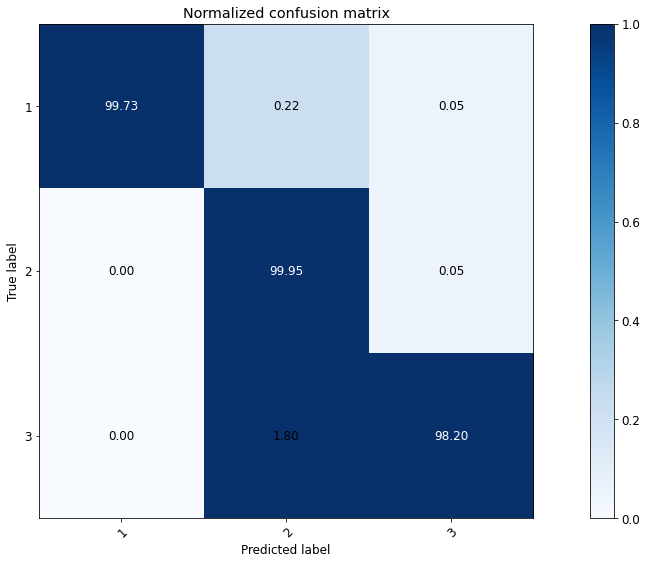

In [ ]:
plot_confusion_matrix(Ytrain_true, predlabel_train, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Normalized confusion matrix
[[96.08695652  3.47826087  0.43478261]
 [ 6.56455142 91.24726477  2.18818381]
 [ 0.42283298  3.38266385 96.19450317]]


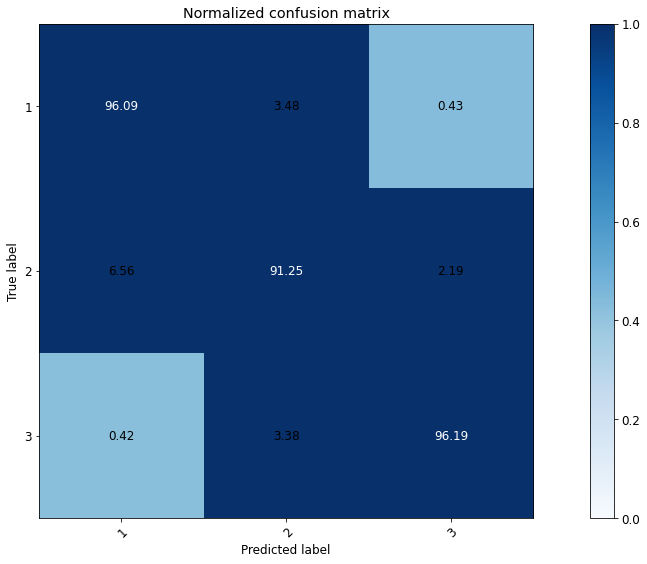

In [ ]:
plot_confusion_matrix(Ytest_true, predlabel_test, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Confidence Interval

In [ ]:
cm_h0= confusion_matrix(Ytest_true, predlabel_test)
print(cm_h0)
confmat_percent(cm_h0).round(2)

[[442  16   2]
 [ 30 417  10]
 [  2  16 455]]


,CL1,CL2,CL3
CL1,96.09,3.48,0.43
CL2,6.56,91.25,2.19
CL3,0.42,3.38,96.19


In [ ]:
cm_h0_df= confmat_df(cm_h0)

In [ ]:
cv= 1.96  # 95% CI= 1.96 and 90% CI= 1.6
confidence_interval(cv, cm_h0_df)  #Testing CI

,Class,Lower Limit,Upper Limit
0,CL1,94.31,97.86
1,CL2,88.66,93.84
2,CL3,94.47,97.92
3,Overall,93.34,95.73


In [ ]:
cm_MLP0_train= confusion_matrix(Ytrain_true,predlabel_train)
cm_MLP0_traindf= confmat_df(cm_MLP0_train)
confidence_interval(cv,cm_MLP0_traindf)  #Training CI

,Class,Lower Limit,Upper Limit
0,CL1,99.57,100.00
1,CL2,96.83,98.25
2,CL3,99.84,100.05
3,Overall,98.85,99.35


## MLP Classification with h* = 638 (sparsity constraint)

*   1st level at target = 10%
*   2nd level at target = 5%




### 1st level at target= 10%

In [ ]:
#define sparsity regularization layer
class SparsityRegularizationLayer(layers.Layer):
  C = 0.10 # A Constant used in the cost formula: Cost(W) = MSE + Constant*CE
  Tar = 0.10 # Target value of % of neurons to be active
  def call(self, inputs):
    avAL = tf.reduce_mean(inputs)
    self.add_loss(  self.C * (  -1*self.Tar*tf.math.log(avAL) + (self.Tar-1)*tf.math.log(1-avAL)  )  )
    return inputs

In [ ]:
# Same input as before as MLP with h0
inputs = keras.Input(shape=(400,)) # 400-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(h_star,activation="sigmoid")(inputs) # Giving this layer the inputs
x1 = SparsityRegularizationLayer()(x1)# Feeding X1 to the spartsity layer
outputs = layers.Dense(3, activation="softmax")(x1) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)

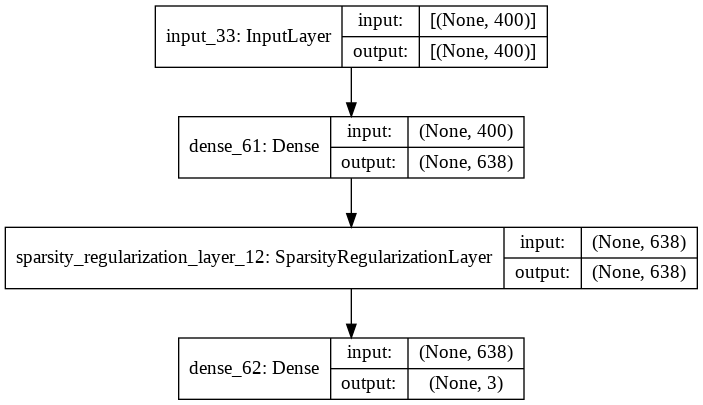

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
start = time.process_time()
my_epochs=300
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
checkpoint=callbacks.ModelCheckpoint(filepath='BestModel.hstar',monitor='val_accuracy',save_best_only=True)
Monitor = model.fit(Xtrain, Ytrain, epochs=my_epochs, batch_size=batch, validation_data=(Xtest,Ytest), callbacks=[checkpoint])
model_h_time = (time.process_time() - start)
print(f"Time to run model: {model_h_time//60} minute {model_h_time%60} seconds")

Epoch 1/300
76/76 [==============================] - 1s 8ms/step - loss: 0.9441 - accuracy: 0.7082 - val_loss: 0.5207 - val_accuracy: 0.8237
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 2/300
76/76 [==============================] - 0s 5ms/step - loss: 0.4861 - accuracy: 0.8421 - val_loss: 0.4441 - val_accuracy: 0.8475
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 3/300
76/76 [==============================] - 0s 5ms/step - loss: 0.3827 - accuracy: 0.8826 - val_loss: 0.3839 - val_accuracy: 0.8683
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 4/300
76/76 [==============================] - 0s 6ms/step - loss: 0.3319 - accuracy: 0.9057 - val_loss: 0.3456 - val_accuracy: 0.8971
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 5/300
76/76 [==============================] - 0s 5ms/step - loss: 0.2675 - accuracy: 0.9341 - val_loss: 0.3097 - val_accuracy: 0.9129
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch

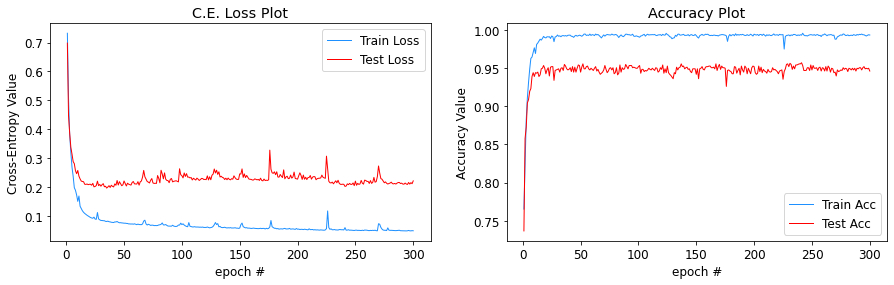

In [ ]:
# Plot when sparsity target = 10%
plot_loss_and_acc(Monitor.history['loss'], Monitor.history['val_loss'],
                  Monitor.history['accuracy'], Monitor.history['val_accuracy'])

(Approximate numbers)

For MLP* w/ sparsitity 10%,
*   Stabilization stabT= 20
*   Overfitting overT= 50 (really none)
*   Stopping Tstop= min(stabT, overT)= 20





### Confusion Matrix at Tstop (for h*)- 10%

---



In [ ]:
#define sparsity regularization layer
class SparsityRegularizationLayer(layers.Layer):
  C = 0.10 # A Constant used in the cost formula: Cost(W) = MSE + Constant*CE
  Tar = 0.10 # Target value of % of neurons to be active
  def call(self, inputs):
    avAL = tf.reduce_mean(inputs)
    self.add_loss(  self.C * (  -1*self.Tar*tf.math.log(avAL) + (self.Tar-1)*tf.math.log(1-avAL)  )  )
    return inputs

In [ ]:
# Same input as before as MLP with h0
inputs = keras.Input(shape=(400,)) # 400-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(h_star,activation="sigmoid")(inputs) # Giving this layer the inputs
x1 = SparsityRegularizationLayer()(x1)# Feeding X1 to the spartsity layer
outputs = layers.Dense(3, activation="softmax")(x1) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
my_epochs= 20     #Value From Tstop
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
checkpoint=callbacks.ModelCheckpoint(filepath='BestModel.hstar_10per_e20',monitor='val_accuracy',save_best_only=True)
model.fit(Xtrain, Ytrain, epochs=my_epochs, batch_size=batch, validation_data=(Xtest,Ytest), callbacks=[checkpoint])

Epoch 1/20
76/76 [==============================] - 1s 7ms/step - loss: 0.8982 - accuracy: 0.7091 - val_loss: 0.5537 - val_accuracy: 0.8079
INFO:tensorflow:Assets written to: BestModel.hstar_10per_e20/assets
Epoch 2/20
76/76 [==============================] - 0s 5ms/step - loss: 0.4644 - accuracy: 0.8431 - val_loss: 0.4343 - val_accuracy: 0.8511
INFO:tensorflow:Assets written to: BestModel.hstar_10per_e20/assets
Epoch 3/20
76/76 [==============================] - 0s 5ms/step - loss: 0.4062 - accuracy: 0.8705 - val_loss: 0.3943 - val_accuracy: 0.8662
INFO:tensorflow:Assets written to: BestModel.hstar_10per_e20/assets
Epoch 4/20
76/76 [==============================] - 0s 5ms/step - loss: 0.3158 - accuracy: 0.9144 - val_loss: 0.3534 - val_accuracy: 0.8885
INFO:tensorflow:Assets written to: BestModel.hstar_10per_e20/assets
Epoch 5/20
76/76 [==============================] - 0s 5ms/step - loss: 0.2671 - accuracy: 0.9346 - val_loss: 0.3077 - val_accuracy: 0.9165
INFO:tensorflow:Assets writt

In [ ]:
model.evaluate(Xtrain,Ytrain)
y_pred_train = model.predict(Xtrain)
predlabel_train = np.argmax(y_pred_train,axis=1)
Ytrain_true= np.argmax(Ytrain,axis=1)
classes = np.asarray(['1','2','3'])

confusion_matrix(Ytrain_true, predlabel_train)

174/174 [==============================] - 0s 2ms/step - loss: 0.0924 - accuracy: 0.9910


array([[1832,    4,    0],
       [   1, 1784,   43],
       [   1,    1, 1886]])

0.9909942363112392
Normalized confusion matrix
[[9.97821351e+01 2.17864924e-01 0.00000000e+00]
 [5.47045952e-02 9.75929978e+01 2.35229759e+00]
 [5.29661017e-02 5.29661017e-02 9.98940678e+01]]


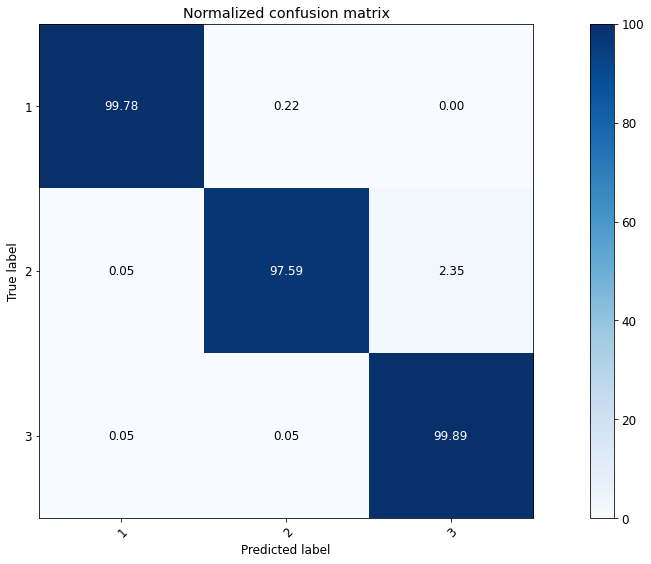

In [ ]:
print(accuracy_score(Ytrain_true, predlabel_train))
plot_confusion_matrix(Ytrain_true, predlabel_train, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model.evaluate(Xtest,Ytest)
y_pred_test = model.predict(Xtest)
predlabel_test = np.argmax(y_pred_test,axis=1)
Ytest_true= np.argmax(Ytest,axis=1)
classes = np.asarray(['1','2','3'])

44/44 [==============================] - 0s 2ms/step - loss: 0.1987 - accuracy: 0.9460


0.9460431654676259
Normalized confusion matrix
[[95.43478261  3.91304348  0.65217391]
 [ 5.03282276 90.37199125  4.595186  ]
 [ 0.21141649  1.90274841 97.8858351 ]]


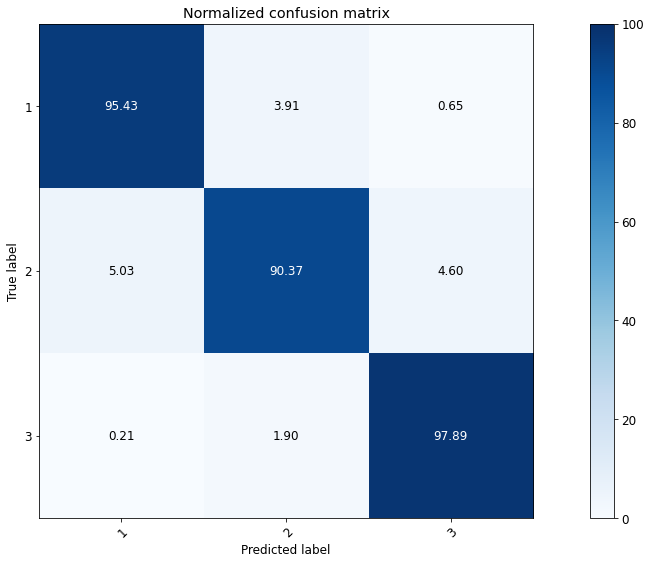

In [ ]:
print(accuracy_score(Ytest_true, predlabel_test))
plot_confusion_matrix(Ytest_true, predlabel_test, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Confidence Interval

In [ ]:
cm_MLPstar_level1= confusion_matrix(Ytest_true, predlabel_test)
print(cm_MLPstar_level1)
confmat_percent(cm_MLPstar_level1).round(2)

[[439  18   3]
 [ 23 413  21]
 [  1   9 463]]


,CL1,CL2,CL3
CL1,95.434783,3.913043,0.652174
CL2,5.032823,90.371991,4.595186
CL3,0.211416,1.902748,97.885835


In [ ]:
confmat_percent(cm_MLPstar_level1).round(2)

,CL1,CL2,CL3
CL1,95.43,3.91,0.65
CL2,5.03,90.37,4.60
CL3,0.21,1.90,97.89


In [ ]:
cm_MLPstar_level1_df= confmat_df(cm_MLPstar_level1)

In [ ]:
cv= 1.96 # 95%CI= 1.96 and 90%CI= 1.6
confidence_interval(cv, cm_MLPstar_level1_df)

,Class,Lower Limit,Upper Limit
0,CL1,93.53,97.34
1,CL2,87.67,93.08
2,CL3,96.59,99.18
3,Overall,93.42,95.79


In [ ]:
cm_MLPstar_level1_train= confusion_matrix(Ytrain_true,predlabel_train)
cm_MLPstar_level1_traindf= confmat_df(cm_MLPstar_level1_train)
confidence_interval(cv,cm_MLPstar_level1_traindf)

,Class,Lower Limit,Upper Limit
0,CL1,99.65,100.02
1,CL2,99.57,100.00
2,CL3,97.54,98.75
3,Overall,99.02,99.47


### 2nd level at target= 5%

In [ ]:
#define sparsity regularization layer
class SparsityRegularizationLayer(layers.Layer):
  C = 0.10 # A Constant used in the cost formula: Cost(W) = MSE + Constant*CE
  Tar = 0.05 # Target value of % of neurons to be active
  def call(self, inputs):
    avAL = tf.reduce_mean(inputs)
    self.add_loss(  self.C * (  -1*self.Tar*tf.math.log(avAL) + (self.Tar-1)*tf.math.log(1-avAL)  )  )
    return inputs

In [ ]:
# Same input as before as MLP with h0
inputs = keras.Input(shape=(400,)) # 400-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(h_star,activation="sigmoid")(inputs) # Giving this layer the inputs
x1 = SparsityRegularizationLayer()(x1)# Feeding X1 to the spartsity layer
outputs = layers.Dense(3, activation="softmax")(x1) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)

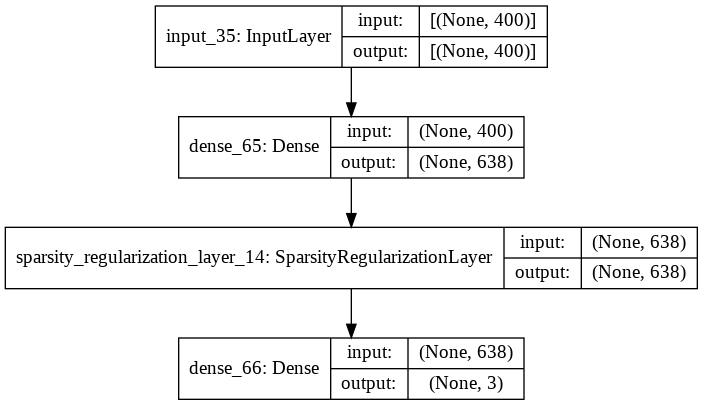

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
start = time.process_time()
my_epochs=300
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
checkpoint=callbacks.ModelCheckpoint(filepath='BestModel.hstar',monitor='val_accuracy',save_best_only=True)
Monitor = model.fit(Xtrain, Ytrain, epochs=my_epochs, batch_size=batch, validation_data=(Xtest,Ytest), callbacks=[checkpoint])
model_h_time = (time.process_time() - start)
print(f"Time to run model: {model_h_time//60} minute {model_h_time%60} seconds")

Epoch 1/300
76/76 [==============================] - 1s 8ms/step - loss: 0.9146 - accuracy: 0.7096 - val_loss: 0.5872 - val_accuracy: 0.8014
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 2/300
76/76 [==============================] - 0s 5ms/step - loss: 0.5855 - accuracy: 0.8072 - val_loss: 0.4728 - val_accuracy: 0.8460
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 3/300
76/76 [==============================] - 0s 5ms/step - loss: 0.4696 - accuracy: 0.8450 - val_loss: 0.4028 - val_accuracy: 0.8683
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 4/300
76/76 [==============================] - 0s 5ms/step - loss: 0.3290 - accuracy: 0.9121 - val_loss: 0.3629 - val_accuracy: 0.8942
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 5/300
76/76 [==============================] - 0s 5ms/step - loss: 0.2707 - accuracy: 0.9387 - val_loss: 0.3282 - val_accuracy: 0.9094
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch

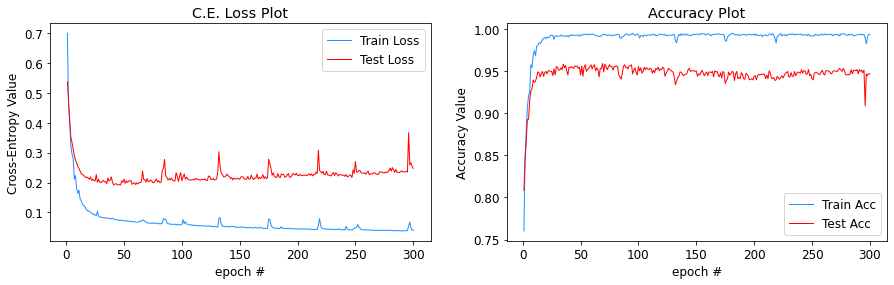

In [ ]:
# Plot when sparsity target = 5%
plot_loss_and_acc(Monitor.history['loss'], Monitor.history['val_loss'],
                  Monitor.history['accuracy'], Monitor.history['val_accuracy'])

(Approximate numbers)

For MLP* w/ sparsitity 5%,
*   Stabilization stabT= 18
*   Overfitting overT= 60 (really none)
*   Stopping Tstop= min(stabT, overT)= 20

### Confusion Matrix at Tstop (for h*)- 5%

In [ ]:
#define sparsity regularization layer
class SparsityRegularizationLayer(layers.Layer):
  C = 0.10 # A Constant used in the cost formula: Cost(W) = MSE + Constant*CE
  Tar = 0.10 # Target value of % of neurons to be active
  def call(self, inputs):
    avAL = tf.reduce_mean(inputs)
    self.add_loss(  self.C * (  -1*self.Tar*tf.math.log(avAL) + (self.Tar-1)*tf.math.log(1-avAL)  )  )
    return inputs

In [ ]:
# Same input as before as MLP with h0
inputs = keras.Input(shape=(400,)) # 400-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(h_star,activation="sigmoid")(inputs) # Giving this layer the inputs
x1 = SparsityRegularizationLayer()(x1)# Feeding X1 to the spartsity layer
outputs = layers.Dense(3, activation="softmax")(x1) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
start = time.process_time()
my_epochs= 20     #Value From Tstop
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
checkpoint=callbacks.ModelCheckpoint(filepath='BestModel.hstar_5per_e20',monitor='val_accuracy',save_best_only=True)
model.fit(Xtrain, Ytrain, epochs=my_epochs, batch_size=batch, validation_data=(Xtest,Ytest), callbacks=[checkpoint])
model_h_time = (time.process_time() - start)
print(f"Time to run model: {model_h_time//60} minute {model_h_time%60} seconds")

Epoch 1/20
76/76 [==============================] - 1s 8ms/step - loss: 0.9119 - accuracy: 0.7132 - val_loss: 0.5905 - val_accuracy: 0.7734
INFO:tensorflow:Assets written to: BestModel.hstar_5per_e20/assets
Epoch 2/20
76/76 [==============================] - 0s 5ms/step - loss: 0.5335 - accuracy: 0.8124 - val_loss: 0.4562 - val_accuracy: 0.8374
INFO:tensorflow:Assets written to: BestModel.hstar_5per_e20/assets
Epoch 3/20
76/76 [==============================] - 0s 5ms/step - loss: 0.3788 - accuracy: 0.8861 - val_loss: 0.4289 - val_accuracy: 0.8504
INFO:tensorflow:Assets written to: BestModel.hstar_5per_e20/assets
Epoch 4/20
76/76 [==============================] - 0s 5ms/step - loss: 0.3198 - accuracy: 0.9099 - val_loss: 0.3371 - val_accuracy: 0.8964
INFO:tensorflow:Assets written to: BestModel.hstar_5per_e20/assets
Epoch 5/20
76/76 [==============================] - 0s 5ms/step - loss: 0.2751 - accuracy: 0.9335 - val_loss: 0.3141 - val_accuracy: 0.9029
INFO:tensorflow:Assets written t

In [ ]:
model.evaluate(Xtrain,Ytrain)
y_pred_train = model.predict(Xtrain)
predlabel_train = np.argmax(y_pred_train,axis=1)
Ytrain_true= np.argmax(Ytrain,axis=1)
classes = np.asarray(['1','2','3'])

confusion_matrix(Ytrain_true, predlabel_train)

174/174 [==============================] - 0s 2ms/step - loss: 0.0936 - accuracy: 0.9924


array([[1833,    3,    0],
       [   2, 1824,    2],
       [   2,   33, 1853]])

In [ ]:
model.evaluate(Xtest,Ytest)
y_pred_test = model.predict(Xtest)
predlabel_test = np.argmax(y_pred_test,axis=1)
Ytest_true= np.argmax(Ytest,axis=1)
classes = np.asarray(['1','2','3'])

confusion_matrix(Ytest_true, predlabel_test)

44/44 [==============================] - 0s 2ms/step - loss: 0.2097 - accuracy: 0.9489


array([[441,  15,   4],
       [ 21, 419,  17],
       [  3,  11, 459]])

0.9924351585014409
Normalized confusion matrix
[[99.83660131  0.16339869  0.        ]
 [ 0.10940919 99.78118162  0.10940919]
 [ 0.1059322   1.74788136 98.14618644]]


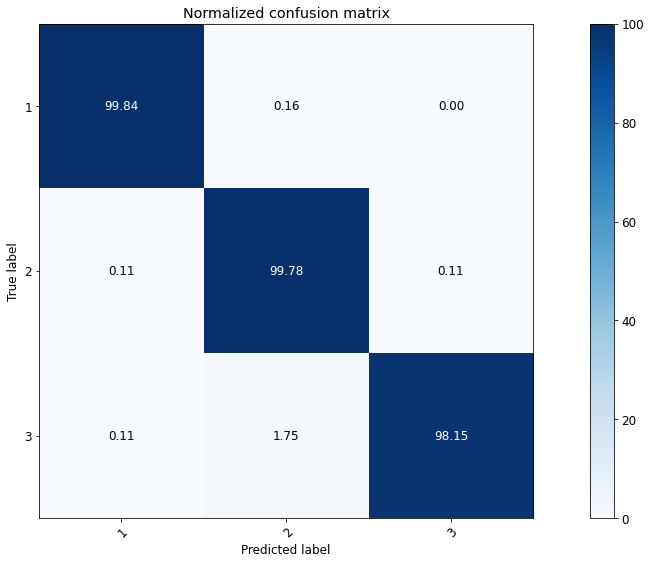

In [ ]:
print(accuracy_score(Ytrain_true, predlabel_train))
plot_confusion_matrix(Ytrain_true, predlabel_train, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

0.9489208633093525
Normalized confusion matrix
[[95.86956522  3.26086957  0.86956522]
 [ 4.595186   91.68490153  3.71991247]
 [ 0.63424947  2.3255814  97.04016913]]


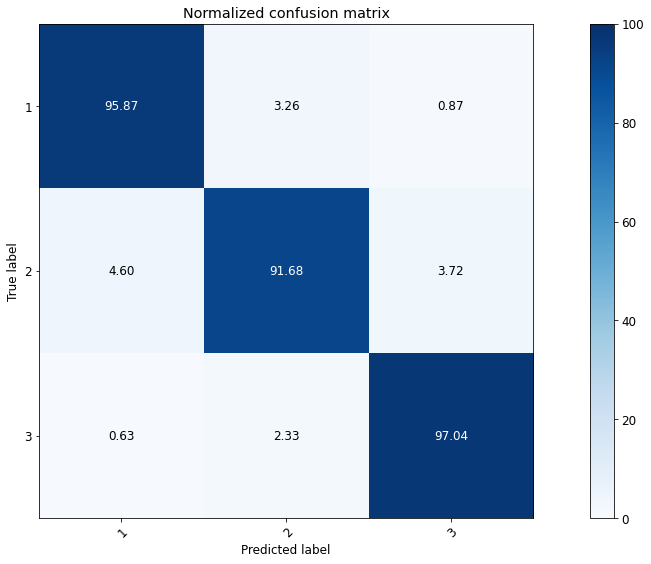

In [ ]:
print(accuracy_score(Ytest_true, predlabel_test))
plot_confusion_matrix(Ytest_true, predlabel_test, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Confidence Interval 

In [ ]:
cm_MLPstar_level2= confusion_matrix(Ytest_true, predlabel_test)
print(cm_MLPstar_level2)
confmat_percent(cm_MLPstar_level2)

[[441  15   4]
 [ 21 419  17]
 [  3  11 459]]


,CL1,CL2,CL3
CL1,95.869565,3.260870,0.869565
CL2,4.595186,91.684902,3.719912
CL3,0.634249,2.325581,97.040169


In [ ]:
cm_MLPstar_level2_df= confmat_df(cm_MLPstar_level2)


In [ ]:
cv= 1.96    #95%CI= 1.96 and 90%CI= 1.6
confidence_interval(cv, cm_MLPstar_level2_df)

,Class,Lower Limit,Upper Limit
0,CL1,94.05,97.69
1,CL2,89.15,94.22
2,CL3,95.51,98.57
3,Overall,93.73,96.05


In [ ]:
cm_MLPstar_level2_train= confusion_matrix(Ytrain_true,predlabel_train)
cm_MLPstar_level2_traindf= confmat_df(cm_MLPstar_level2_train)
confidence_interval(cv,cm_MLPstar_level2_traindf)

,Class,Lower Limit,Upper Limit
0,CL1,99.65,100.02
1,CL2,99.57,100.00
2,CL3,97.54,98.75
3,Overall,99.02,99.47


## **Notes**

Among h* sparsity models at 10% and 5%, h*=638 with 10% sparsity was best with 94.68% accuracy. So, for MLP'**', 10% sparsity model should be kept.

Among all three models (MLP0, MLP* @ 10% sparsity, and MLP* @ 5% sparsity),
MLP0 had the highest overall accuracy of 95.40% with very minimal difference from other two model (MLP* at 10% sparsity- 94.68%, MLP* at 5% sparsity- 94.32%)


# Tasks 5 & 6 - Histogram of ACTn + Per(1/2) & Per(1/3)

In [ ]:
# Function for Hidden Layer Anlysis

# Models that can are saved are ['BestModel.h100_e50','BestModel.hstar_10per_e20','BestModel.hstar_5per_e20']
def HLA(my_cases, blurb='For', model_to_use = 'BestModel.hstar_10per_e20'):
  model = load_model(model_to_use)
  ACTn = np.mean(model.layers[1](my_cases).numpy(), axis=1)
  avact = round(sum(ACTn)/len(ACTn), 4)
  per_1half = round((sum(ACTn < avact/2)/len(ACTn))*100, 4)
  per_1third = round((sum(ACTn < avact/3)/len(ACTn))*100, 4)
  print(blurb)
  print("   The average activity of the neurons in the hidden layer is " + str(avact))
  print("   per(1/2): " + str(per_1half))
  print("   per(1/3): " + str(per_1third))
  print("\n")

  # Plots the histogram of ACTn
  fig = plt.figure()
  plt.figure(figsize=(9,5))
  plt.hist(ACTn)#, bins=range(-8, 9))
  plt.axvline(x=avact, color = 'red')
  plt.ylabel('Frequency', fontsize=16)
  plt.xlabel('Activity Level', fontsize=16)
  plt.title('Histogram of Average Neuron States in Hidden Layer')
  plt.xticks([.4, .425, .45, .475, .5, .525, .55, .575, .6])

For All Classes:
   The average activity of the neurons in the hidden layer is 0.4798
   per(1/2): 0.0
   per(1/3): 0.0




<Figure size 432x288 with 0 Axes>

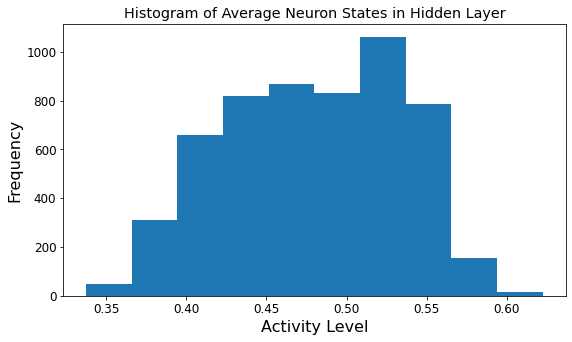

In [ ]:
HLA(Xtrain, "For All Classes:")

# Task 5 & 6 Bonus

For Class 1:
   The average activity of the neurons in the hidden layer is 0.4587
   per(1/2): 0.0
   per(1/3): 0.0




<Figure size 432x288 with 0 Axes>

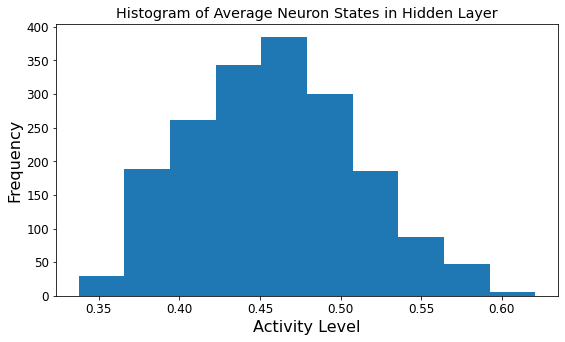

In [ ]:
HLA(font1_Xtrain, "For Class 1:")

For Class 2:
   The average activity of the neurons in the hidden layer is 0.4702
   per(1/2): 0.0
   per(1/3): 0.0




<Figure size 432x288 with 0 Axes>

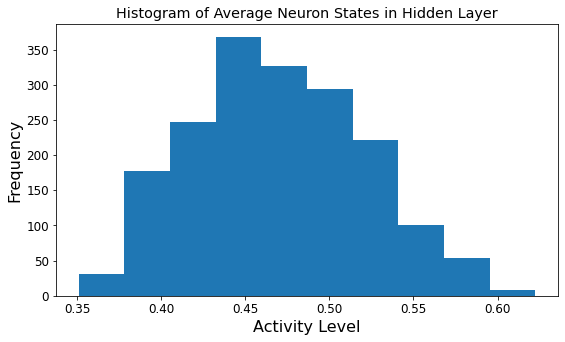

In [ ]:
HLA(font2_Xtrain, "For Class 2:")

For Class 3:
   The average activity of the neurons in the hidden layer is 0.5095
   per(1/2): 0.0
   per(1/3): 0.0




<Figure size 432x288 with 0 Axes>

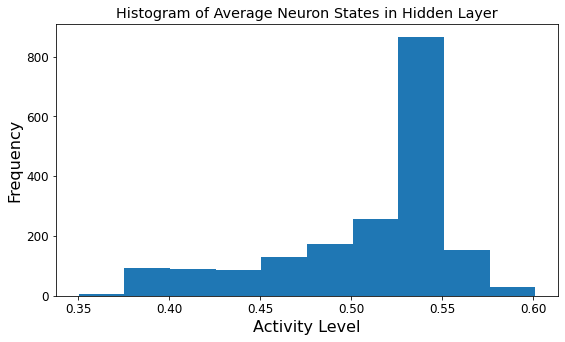

In [ ]:
HLA(font3_Xtrain, "For Class 3:")

# Task 6.? Scatter Plot of first 3 PCs in Hidden Layer

In [ ]:
def Plot3D_PCA(my_cases, my_title='3D Scatter Plot', model_to_use = 'BestModel.hstar_10per_e20'): 
  # This function assumes that you are using all cases and that they are in order. 
  n1 = 2296
  n2 = 2285
  n3 = 2361
  model = load_model(model_to_use)
  ACTN = model.layers[1](my_cases).numpy() # This is the hidden layer of the model with "my_cases" fed into it.
  ACTN_scaled = StandardScaler().fit_transform(ACTN)  
  ACTN_CORR = np.corrcoef(ACTN_scaled.T)
  ACTN_v, ACTN_w = LA.eig(ACTN_CORR)
  PCA_feats = (ACTN_w.T@ACTN.T).T # These are the cases projected onto the principle components of the hidden layer.
       
  CL1_X, CL1_Y, CL1_Z = (PCA_feats[:n1, 0], PCA_feats[:n1, 1], PCA_feats[:n1, 2])
  CL2_X, CL2_Y, CL2_Z = (PCA_feats[n1:(n1+n2), 0], PCA_feats[n1:(n1+n2), 1], PCA_feats[n1:(n1+n2), 2])
  CL3_X, CL3_Y, CL3_Z = (PCA_feats[(n1+n2):, 0], PCA_feats[(n1+n2):, 1], PCA_feats[(n1+n2):, 2])
  
  # Creating figure
  fig = plt.figure(figsize = (10, 7))
  ax = plt.axes(projection ="3d")
  
  # Creating plot
  scatter1 = ax.scatter3D(CL1_X, CL1_Y, CL1_Z, color = "green")
  scatter2 = ax.scatter3D(CL2_X, CL2_Y, CL2_Z, color = "blue")
  scatter3 = ax.scatter3D(CL3_X, CL3_Y, CL3_Z, color = "red")
  ax.legend([scatter1, scatter2, scatter3], ['Class 1', 'Class 2', 'Class 3'])
  ax.set_xlabel('Principle Component 1')
  ax.set_ylabel('Principle Component 2')
  ax.set_zlabel('Principle Component 3')
  plt.title(my_title)
  
  # show plot
  plt.show()

In [ ]:
Plot3D_PCA(X, my_title = '3D Scatter Plot of Hidden Layer Principle Componenets')

# Task 6.?  Class Responders

[284, 275, 79]


<Figure size 432x288 with 0 Axes>

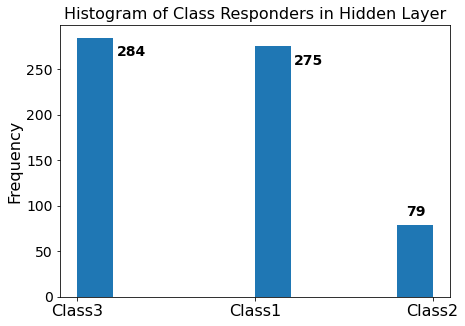

In [ ]:
def Class_Responder(CL1, CL2, CL3, model_to_use = 'BestModel.hstar_10per_e20'): 
  model = load_model(model_to_use)
  ACTN_CL1 = np.mean(model.layers[1](CL1).numpy(), axis=0)
  ACTN_CL2 = np.mean(model.layers[1](CL2).numpy(), axis=0)
  ACTN_CL3 = np.mean(model.layers[1](CL3).numpy(), axis=0)
  goober = np.vstack((ACTN_CL1, ACTN_CL2, ACTN_CL3))
  Responder = []
  for i in range(638):
    fox = np.where(goober[:,i]==np.max(goober[:,i]))[0][0] + 1
    Responder.append(fox)
  
  gox = pd.Series(Responder)#, dtype="category")
  hox = []
  for i in gox:
    jox = "Class" + str(i)
    hox.append(jox)
  
  kox = sorted([sum(np.array(Responder)==1), sum(np.array(Responder)==2), sum(np.array(Responder)==3)], reverse=True)

  # Plots the histogram of class responders
  fig = plt.figure()
  plt.figure(figsize=(7,5))
  plt.hist(hox) 
  plt.ylabel('Frequency', fontsize=16)
  #plt.xlabel('Class', fontsize=16)
  plt.title('Histogram of Class Responders in Hidden Layer', fontsize=16)
  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 14)
  plt.text(0.22, (kox[0] - 20), str(kox[0]), color='black', fontweight='bold', fontsize = 14)
  plt.text(1.22, (kox[1] - 20), str(kox[1]), color='black', fontweight='bold', fontsize = 14)
  plt.text(1.85, (kox[2] + 10), str(kox[2]), color='black', fontweight='bold', fontsize = 14)
  print(kox)



In [ ]:
Class_Responder(font1_X_scaled, font2_X_scaled, font3_X_scaled)

# Task 7 PC of Zn

In [ ]:
model = load_model('BestModel.hstar_5per_e20')

In [ ]:
Zn = model.layers[1](Xtrain).numpy()
Zn_test = model.layers[1](Xtest).numpy()
All_Zn = model.layers[1](X_scaled).numpy()

In [ ]:
# Doing PCA to find the dim of H1 (num of neurons for hidden layer h1)
Zn_scaled = StandardScaler().fit_transform(All_Zn)
Zn_CORR = np.corrcoef(Zn_scaled.T)
Zn_v, Zn_w = LA.eig(Zn_CORR)

Zn_PVE_vector = []
Zn_PVE_sum = 0
for i in Zn_v:
  Zn_PVE_sum += 100*i/sum(Zn_v)
  Zn_PVE_vector.append(round(Zn_PVE_sum, 2))

box11 = np.asarray(Zn_PVE_vector)
H1_dim = np.where(box11>95)[0][0] + 1
print('H1 dim is: ', H1_dim)

H1 dim is:  138


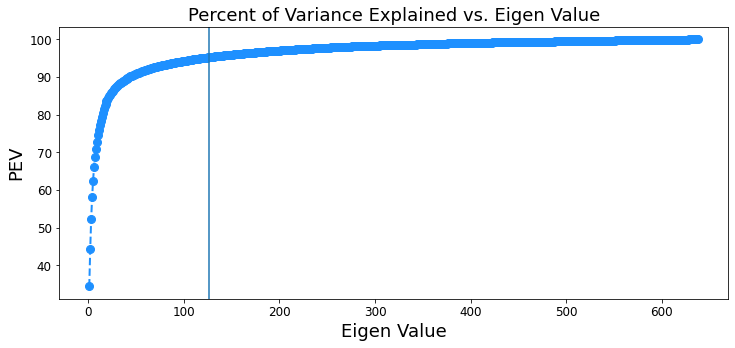

In [ ]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(range(1,(len(Zn_PVE_vector)+1)), Zn_PVE_vector, color='dodgerblue', marker='o', linestyle='dashed', linewidth=2, markersize=8)
plt.xlabel('Eigen Value', fontsize=18)
plt.ylabel('PEV', fontsize=18)
plt.title('Percent of Variance Explained vs. Eigen Value', fontsize=18)
plt.axvline(x=120)
plt.show;

# Task 8 Autoencoder

In [ ]:
# S = 120

In [ ]:
inputs = keras.Input(shape=(638,)) # 638-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(H1_dim,activation="sigmoid")(inputs) # Giving this layer the inputs
outputs = layers.Dense(638, activation="sigmoid")(x1) # Output layer with 638 classes (dim of (Z'n))

model = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
loss_fn = losses.MeanSquaredError() # defines the loss function to use
optimizer = optimizers.Adam() # LR 0.001 is the default

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn)

In [ ]:
All_Zn_batch = int(All_Zn.shape[0]**.5)

In [ ]:
start = time.process_time()
checkpoint=callbacks.ModelCheckpoint(filepath='BestModel_task8.h',monitor='loss',save_best_only=True)
Monitor = model.fit(All_Zn, All_Zn, epochs=100, batch_size=All_Zn_batch,
          callbacks=[checkpoint])
# validation_data=(Zn_test,Zn_test),
model_h_time = (time.process_time() - start)
print(f"Time to run model: {model_h_time//60} minutes {model_h_time%60} seconds")

Epoch 1/100
84/84 [==============================] - 1s 4ms/step - loss: 0.1444
INFO:tensorflow:Assets written to: BestModel_task8.h/assets
Epoch 2/100
84/84 [==============================] - 0s 5ms/step - loss: 0.0776
INFO:tensorflow:Assets written to: BestModel_task8.h/assets
Epoch 3/100
84/84 [==============================] - 0s 5ms/step - loss: 0.0574
INFO:tensorflow:Assets written to: BestModel_task8.h/assets
Epoch 4/100
84/84 [==============================] - 0s 5ms/step - loss: 0.0467
INFO:tensorflow:Assets written to: BestModel_task8.h/assets
Epoch 5/100
84/84 [==============================] - 0s 5ms/step - loss: 0.0390
INFO:tensorflow:Assets written to: BestModel_task8.h/assets
Epoch 6/100
84/84 [==============================] - 0s 5ms/step - loss: 0.0337
INFO:tensorflow:Assets written to: BestModel_task8.h/assets
Epoch 7/100
84/84 [==============================] - 0s 5ms/step - loss: 0.0296
INFO:tensorflow:Assets written to: BestModel_task8.h/assets
Epoch 8/100
84/84 [=

In [ ]:
def plot_mseloss_and_acc(train_loss): #, train_loss, val_loss,train_acc, val_acc
  fig = plt.figure(figsize= (15,4))
  ax1 = fig.add_subplot(1,2,1)
  # Train & Test Loss plot
  plt.plot(range(1,(len(train_loss)+1)), train_loss, color='dodgerblue', linewidth=1, markersize=6) # Train Loss
  # plt.plot(range(1,(len(train_loss)+1)), val_loss, color='red', linewidth=1, markersize=6) # Test Loss
  plt.xlabel('epoch #')
  plt.ylabel('MSE')
  plt.title('MSE Loss Plot - Autoencoder')
  plt.legend(['MSE Loss', 'Test Loss'])

  # ax1 = fig.add_subplot(1,2,2)
  # # Train & Test Accuracy plot
  # plt.plot(range(1,(len(train_acc)+1)), train_acc, color='dodgerblue', linewidth=1, markersize=6) # Train Loss
  # # plt.plot(range(1,(len(train_acc)+1)), val_acc, color='red', linewidth=1, markersize=6) # Test Loss
  # plt.xlabel('epoch #')
  # plt.ylabel('Accuracy Value')
  # plt.title('Accuracy Plot')
  # plt.legend(['Train Acc', 'Test Acc']);

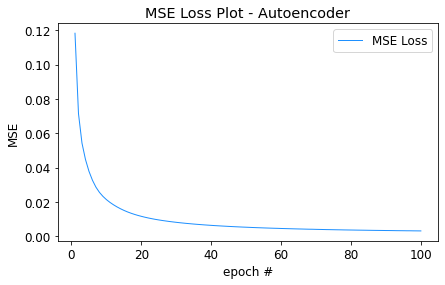

In [ ]:
# plot_mseloss_and_acc(Monitor.history['loss'], Monitor.history['val_loss'],
#                   Monitor.history['accuracy'], Monitor.history['val_accuracy'])
plot_mseloss_and_acc(Monitor.history['loss'])

In [ ]:
autoencoder = load_model('BestModel_task8.h')

In [ ]:
min(Monitor.history['loss'])

0.0030764807015657425

In [ ]:
np.sqrt(min(Monitor.history['loss']))/np.mean(LA.norm(Zn, axis=1))

0.003479656928602099

# Task 9a and 9b - Finding Kn, Short MLP and MLP**

### 9a

In [ ]:
Kn = autoencoder.layers[1](Zn).numpy() # lol thats it for Part 9-a?

In [ ]:
Kn.shape # Dim S = 120

(5552, 138)

In [ ]:
Kn_test = autoencoder.layers[1](Zn_test).numpy()

In [ ]:
Kn_test.shape

(1390, 138)

### 9b - Short MLP

In [ ]:
# Functional API - More power full than the Sequential API. Using this kind of model, allows us to create sequential models as well as many other types of models.

inputs = keras.Input(shape=(H1_dim,)) # 400-dimonsional vector and Batch size not specified since it can vary.
# Use dim of Kn... in this case, same as H1_dim
outputs = layers.Dense(3, activation="softmax")(inputs) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
model.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 138)]             0         
_________________________________________________________________
dense_56 (Dense)             (None, 3)                 417       
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss_fn = losses.CategoricalCrossentropy()
optimizer = optimizers.Adam() # LR 0.001 is the default

In [ ]:
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])

In [ ]:
start = time.process_time()
checkpoint=callbacks.ModelCheckpoint(filepath='ShortModel',monitor='val_accuracy',save_best_only=True)
Monitor = model.fit(Kn, Ytrain, epochs=300, batch_size=batch, validation_data=(Kn_test,Ytest), callbacks=[checkpoint])
model_h_time = (time.process_time() - start)
print(f"Time to run model: {model_h_time//60} minutes {model_h_time%60} seconds")

Epoch 1/300
76/76 [==============================] - 1s 4ms/step - loss: 1.0881 - accuracy: 0.4007 - val_loss: 0.7829 - val_accuracy: 0.6612
INFO:tensorflow:Assets written to: ShortModel/assets
Epoch 2/300
76/76 [==============================] - 0s 2ms/step - loss: 0.7321 - accuracy: 0.7091 - val_loss: 0.6339 - val_accuracy: 0.7813
INFO:tensorflow:Assets written to: ShortModel/assets
Epoch 3/300
76/76 [==============================] - 0s 2ms/step - loss: 0.6033 - accuracy: 0.8028 - val_loss: 0.5514 - val_accuracy: 0.8331
INFO:tensorflow:Assets written to: ShortModel/assets
Epoch 4/300
76/76 [==============================] - 0s 2ms/step - loss: 0.5125 - accuracy: 0.8463 - val_loss: 0.4988 - val_accuracy: 0.8417
INFO:tensorflow:Assets written to: ShortModel/assets
Epoch 5/300
76/76 [==============================] - 0s 2ms/step - loss: 0.4520 - accuracy: 0.8782 - val_loss: 0.4556 - val_accuracy: 0.8583
INFO:tensorflow:Assets written to: ShortModel/assets
Epoch 6/300
76/76 [===========

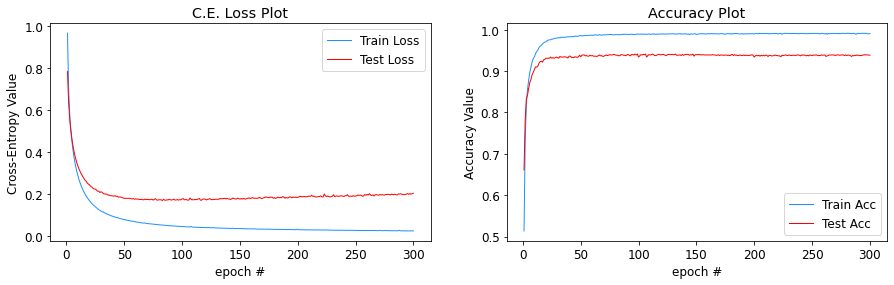

In [ ]:
plot_loss_and_acc(Monitor.history['loss'], Monitor.history['val_loss'],
                  Monitor.history['accuracy'], Monitor.history['val_accuracy'])

# OverFit epoch = 100
# Stablization epoch = 60

### MLP**

In [ ]:
# Functional API - More power full than the Sequential API. Using this kind of model, allows us to create sequential models as well as many other types of models.

inputs = keras.Input(shape=(H1_dim,)) # 138-dimonsional vector and Batch size not specified since it can vary.
outputs = layers.Dense(3, activation="softmax")(inputs) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
model.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 138)]             0         
_________________________________________________________________
dense_58 (Dense)             (None, 3)                 417       
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss_fn = losses.CategoricalCrossentropy()
optimizer = optimizers.Adam() # LR 0.001 is the default

In [ ]:
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])

In [ ]:
start = time.process_time()
checkpoint=callbacks.ModelCheckpoint(filepath='ShortModel',monitor='val_accuracy',save_best_only=True)
Monitor = model.fit(Kn, Ytrain, epochs=60, batch_size=batch, validation_data=(Kn_test,Ytest), callbacks=[checkpoint])
model_h_time = (time.process_time() - start)
print(f"Time to run model: {model_h_time//60} minutes {model_h_time%60} seconds")

Epoch 1/60
76/76 [==============================] - 1s 4ms/step - loss: 1.0882 - accuracy: 0.4352 - val_loss: 0.7922 - val_accuracy: 0.6899
INFO:tensorflow:Assets written to: ShortModel/assets
Epoch 2/60
76/76 [==============================] - 0s 2ms/step - loss: 0.7329 - accuracy: 0.7403 - val_loss: 0.6415 - val_accuracy: 0.7835
INFO:tensorflow:Assets written to: ShortModel/assets
Epoch 3/60
76/76 [==============================] - 0s 2ms/step - loss: 0.6022 - accuracy: 0.8073 - val_loss: 0.5577 - val_accuracy: 0.8237
INFO:tensorflow:Assets written to: ShortModel/assets
Epoch 4/60
76/76 [==============================] - 0s 2ms/step - loss: 0.5168 - accuracy: 0.8433 - val_loss: 0.5014 - val_accuracy: 0.8417
INFO:tensorflow:Assets written to: ShortModel/assets
Epoch 5/60
76/76 [==============================] - 0s 2ms/step - loss: 0.4518 - accuracy: 0.8793 - val_loss: 0.4608 - val_accuracy: 0.8561
INFO:tensorflow:Assets written to: ShortModel/assets
Epoch 6/60
76/76 [=================

In [ ]:
model = load_model('ShortModel')

In [ ]:
model.evaluate(Kn, Ytrain)
y_pred_train = model.predict(Kn)
predlabel_train = np.argmax(y_pred_train,axis=1)
Ytrain_true= np.argmax(Ytrain,axis=1)
classes = np.asarray(['1','2','3'])

confusion_matrix(Ytrain_true, predlabel_train)

174/174 [==============================] - 0s 999us/step - loss: 0.0668 - accuracy: 0.9869


array([[1818,   18,    0],
       [   8, 1817,    3],
       [   4,   40, 1844]])

In [ ]:
model.evaluate(Kn_test,Ytest)
y_pred_test = model.predict(Kn_test)
predlabel_test = np.argmax(y_pred_test,axis=1)
Ytest_true= np.argmax(Ytest,axis=1)
classes = np.asarray(['1','2','3'])

confusion_matrix(Ytest_true, predlabel_test)

44/44 [==============================] - 0s 951us/step - loss: 0.1757 - accuracy: 0.9403


array([[446,  10,   4],
       [ 28, 409,  20],
       [  3,  18, 452]])

0.9868515850144092
Normalized confusion matrix
[[99.01960784  0.98039216  0.        ]
 [ 0.43763676 99.39824945  0.16411379]
 [ 0.21186441  2.11864407 97.66949153]]


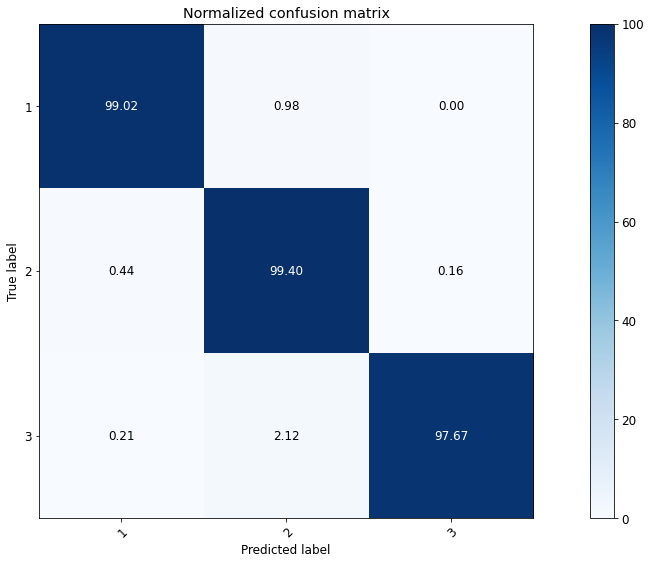

In [ ]:
print(accuracy_score(Ytrain_true, predlabel_train))
plot_confusion_matrix(Ytrain_true, predlabel_train, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

0.9402877697841726
Normalized confusion matrix
[[96.95652174  2.17391304  0.86956522]
 [ 6.12691466 89.49671772  4.37636761]
 [ 0.63424947  3.80549683 95.5602537 ]]


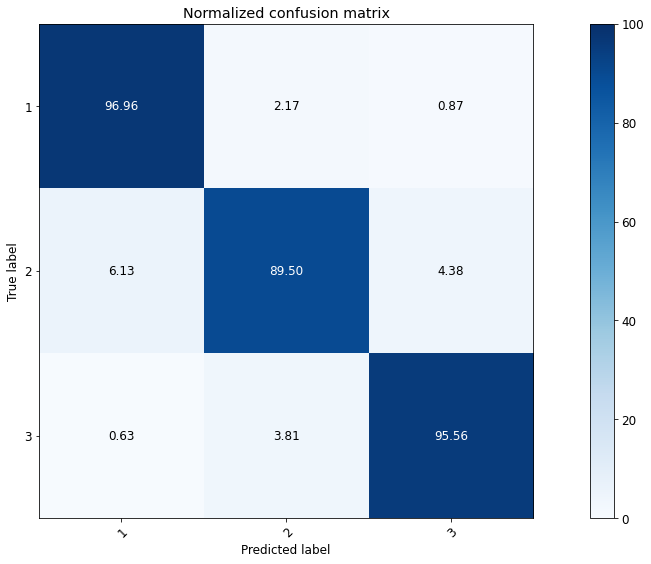

In [ ]:
print(accuracy_score(Ytest_true, predlabel_test))
plot_confusion_matrix(Ytest_true, predlabel_test, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
type(model.layers[1])

tensorflow.python.keras.layers.core.Dense

#### Confidence Interval

In [ ]:
cm_MLPstar_star= confusion_matrix(Ytest_true, predlabel_test)
print(cm_MLPstar_star)
confmat_percent(cm_MLPstar_star).round(2)

[[446  10   4]
 [ 28 409  20]
 [  3  18 452]]


,CL1,CL2,CL3
CL1,96.956522,2.173913,0.869565
CL2,6.126915,89.496718,4.376368
CL3,0.634249,3.805497,95.560254


In [ ]:
confmat_percent(cm_MLPstar_star).round(2)

,CL1,CL2,CL3
CL1,96.96,2.17,0.87
CL2,6.13,89.50,4.38
CL3,0.63,3.81,95.56


In [ ]:
cm_MLPstar_star_df= confmat_df(cm_MLPstar_star)

In [ ]:
cv= 1.96 # 95%CI= 1.96 and 90%CI= 1.6
confidence_interval(cv, cm_MLPstar_star_df)

,Class,Lower Limit,Upper Limit
0,CL1,95.39,98.53
1,CL2,86.69,92.31
2,CL3,93.70,97.42
3,Overall,92.78,95.27


In [ ]:
cm_MLPstar_star_train= confusion_matrix(Ytrain_true,predlabel_train)
cm_MLPstar_star_traindf= confmat_df(cm_MLPstar_star_train)
confidence_interval(cv,cm_MLPstar_star_traindf)

,Class,Lower Limit,Upper Limit
0,CL1,98.57,99.47
1,CL2,99.04,99.75
2,CL3,96.99,98.35
3,Overall,98.39,98.98


Confidence Interval Observations
- Train and Testset CIs do not overlap. Disjoint CIs. Train perf>Test perf
- The range of all MLPs CI are similar w/ CI of MLP** being widest w/ very little difference.
- The CI of CL2 in MLP** (85.22<X<91.14) is comparatively lower than CI than selected MLP_star (90.15<X<94.97). 

-------------------------------

# **Testing random things**

In [ ]:
#model.layers[0](Xtrain).numpy()[0]
model.layers[2](Xtrain).numpy().shape

### Testing other levels

In [ ]:
#define sparsity regularization layer
class SparsityRegularizationLayer(layers.Layer):
  C = 0.10 # A Constant used in the cost formula: Cost(W) = MSE + Constant*CE
  Tar = 0.20 # Target value of % of neurons to be active
  def call(self, inputs):
    avAL = tf.reduce_mean(inputs)
    self.add_loss(  self.C * (  -1*self.Tar*tf.math.log(avAL) + (self.Tar-1)*tf.math.log(1-avAL)  )  )
    return inputs

In [ ]:
# Same input as before as MLP with h0
inputs = keras.Input(shape=(400,)) # 400-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(h_star,activation="sigmoid")(inputs) # Giving this layer the inputs
x1 = SparsityRegularizationLayer()(x1)# Feeding X1 to the spartsity layer
outputs = layers.Dense(3, activation="softmax")(x1) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)

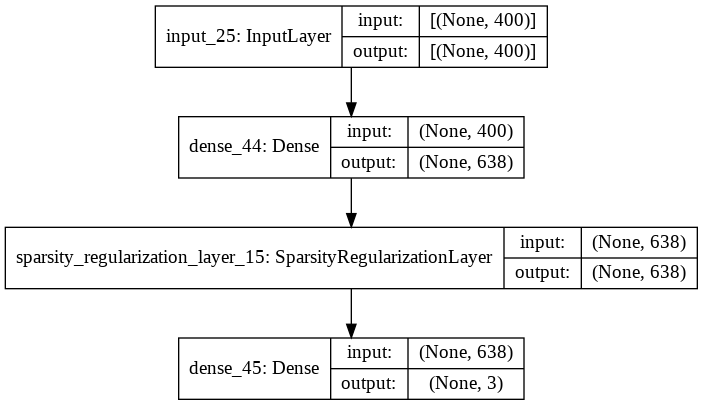

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
my_epochs=100
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
checkpoint=callbacks.ModelCheckpoint(filepath='BestModel.hstar',monitor='val_accuracy',save_best_only=True)
Monitor = model.fit(Xtrain, Ytrain, epochs=my_epochs, batch_size=batch, validation_data=(Xtest,Ytest), callbacks=[checkpoint])

Epoch 1/100
76/76 [==============================] - 1s 7ms/step - loss: 1.0068 - accuracy: 0.7108 - val_loss: 0.5672 - val_accuracy: 0.8029
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 2/100
76/76 [==============================] - 0s 5ms/step - loss: 0.5324 - accuracy: 0.8272 - val_loss: 0.4972 - val_accuracy: 0.8345
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 3/100
76/76 [==============================] - 0s 5ms/step - loss: 0.4814 - accuracy: 0.8544 - val_loss: 0.3977 - val_accuracy: 0.8827
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 4/100
76/76 [==============================] - 0s 5ms/step - loss: 0.3406 - accuracy: 0.9032 - val_loss: 0.3802 - val_accuracy: 0.8712
Epoch 5/100
76/76 [==============================] - 0s 4ms/step - loss: 0.2923 - accuracy: 0.9258 - val_loss: 0.3581 - val_accuracy: 0.8928
INFO:tensorflow:Assets written to: BestModel.hstar/assets
Epoch 6/100
76/76 [==============================] - 0s 5ms/ste

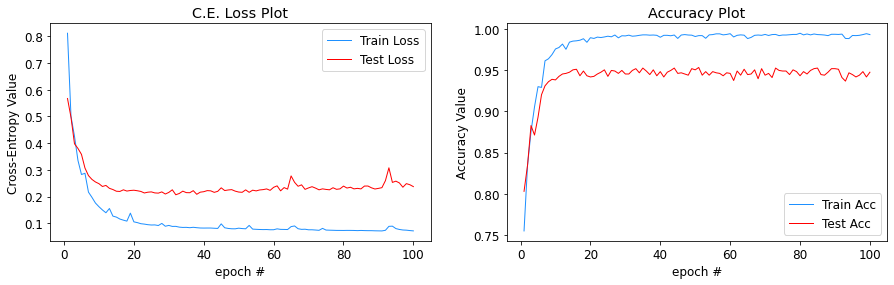

In [ ]:
# Plot when sparsity target = 5%
plot_loss_and_acc(Monitor.history['loss'], Monitor.history['val_loss'],
                  Monitor.history['accuracy'], Monitor.history['val_accuracy'])

(Approximate numbers)

For MLP* w/ sparsitity 20%,
*   Stabilization stabT= 27
*   Overfitting overT= 60 
*   Stopping Tstop= min(stabT, overT)= 27

### Confusion Matrix at Tstop (for h*)

---



In [ ]:
#define sparsity regularization layer
class SparsityRegularizationLayer(layers.Layer):
  C = 0.10 # A Constant used in the cost formula: Cost(W) = MSE + Constant*CE
  Tar = 0.10 # Target value of % of neurons to be active
  def call(self, inputs):
    avAL = tf.reduce_mean(inputs)
    self.add_loss(  self.C * (  -1*self.Tar*tf.math.log(avAL) + (self.Tar-1)*tf.math.log(1-avAL)  )  )
    return inputs

In [ ]:
# Same input as before as MLP with h0
inputs = keras.Input(shape=(400,)) # 400-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(h_star,activation="sigmoid")(inputs) # Giving this layer the inputs
x1 = SparsityRegularizationLayer()(x1)# Feeding X1 to the spartsity layer
outputs = layers.Dense(3, activation="softmax")(x1) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
my_epochs= 27     #Value From Tstop
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
checkpoint=callbacks.ModelCheckpoint(filepath='BestModel.hstar_10per_e20',monitor='val_accuracy',save_best_only=True)
model.fit(Xtrain, Ytrain, epochs=my_epochs, batch_size=batch, validation_data=(Xtest,Ytest), callbacks=[checkpoint])

Epoch 1/27
76/76 [==============================] - 1s 7ms/step - loss: 0.9785 - accuracy: 0.7061 - val_loss: 0.5839 - val_accuracy: 0.7784
INFO:tensorflow:Assets written to: BestModel.hstar_10per_e20/assets
Epoch 2/27
76/76 [==============================] - 0s 5ms/step - loss: 0.5437 - accuracy: 0.8121 - val_loss: 0.4614 - val_accuracy: 0.8417
INFO:tensorflow:Assets written to: BestModel.hstar_10per_e20/assets
Epoch 3/27
76/76 [==============================] - 0s 5ms/step - loss: 0.4350 - accuracy: 0.8578 - val_loss: 0.4146 - val_accuracy: 0.8669
INFO:tensorflow:Assets written to: BestModel.hstar_10per_e20/assets
Epoch 4/27
76/76 [==============================] - 0s 5ms/step - loss: 0.3390 - accuracy: 0.9037 - val_loss: 0.3698 - val_accuracy: 0.8899
INFO:tensorflow:Assets written to: BestModel.hstar_10per_e20/assets
Epoch 5/27
76/76 [==============================] - 0s 5ms/step - loss: 0.2746 - accuracy: 0.9342 - val_loss: 0.3169 - val_accuracy: 0.9129
INFO:tensorflow:Assets writt

In [ ]:
model.evaluate(Xtrain,Ytrain)
y_pred_train = model.predict(Xtrain)
predlabel_train = np.argmax(y_pred_train,axis=1)
Ytrain_true= np.argmax(Ytrain,axis=1)
classes = np.asarray(['1','2','3'])

confusion_matrix(Ytrain_true, predlabel_train)

174/174 [==============================] - 0s 2ms/step - loss: 0.0892 - accuracy: 0.9912


array([[1833,    2,    1],
       [   1, 1782,   45],
       [   0,    0, 1888]])

Normalized confusion matrix
[[9.98366013e+01 1.08932462e-01 5.44662309e-02]
 [5.47045952e-02 9.74835886e+01 2.46170678e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+02]]


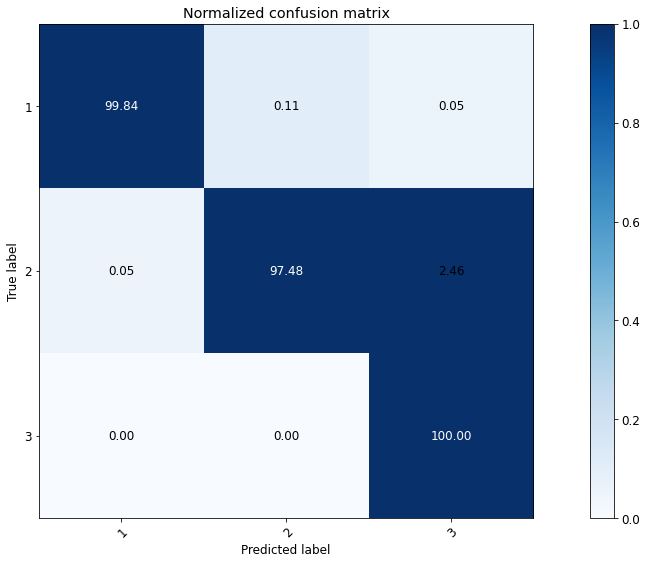

In [ ]:
plot_confusion_matrix(Ytrain_true, predlabel_train, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model.evaluate(Xtest,Ytest)
y_pred_test = model.predict(Xtest)
predlabel_test = np.argmax(y_pred_test,axis=1)
Ytest_true= np.argmax(Ytest,axis=1)
classes = np.asarray(['1','2','3'])

44/44 [==============================] - 0s 2ms/step - loss: 0.2069 - accuracy: 0.9525


0.9525179856115108
Normalized confusion matrix
[[96.52173913  2.60869565  0.86956522]
 [ 3.28227571 90.37199125  6.34573304]
 [ 0.          1.26849894 98.73150106]]


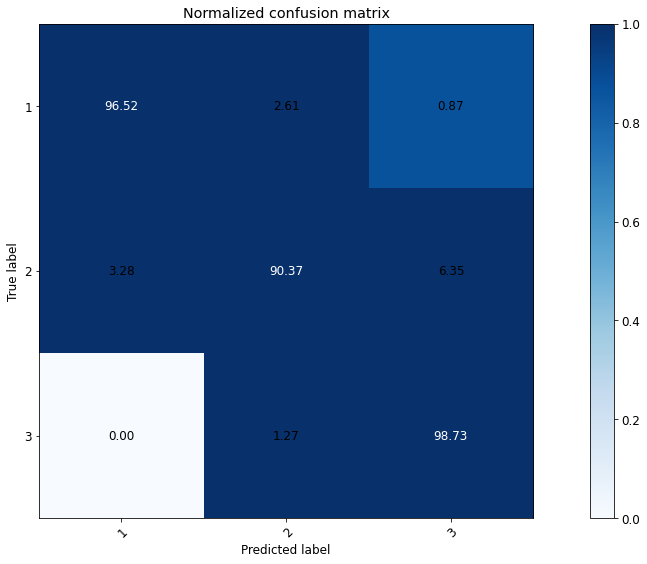

In [ ]:
print(accuracy_score(Ytest_true, predlabel_test))
plot_confusion_matrix(Ytest_true, predlabel_test, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Confidence Interval

In [ ]:
cm_MLPstar_level3= confusion_matrix(Ytest_true, predlabel_test)
print(cm_MLPstar_level3)
confmat_percent(cm_MLPstar_level3)

[[444  12   4]
 [ 15 413  29]
 [  0   6 467]]


,CL1,CL2,CL3
CL1,96.521739,2.608696,0.869565
CL2,3.282276,90.371991,6.345733
CL3,0.000000,1.268499,98.731501


In [ ]:
cm_MLPstar_level3_df= confmat_df(cm_MLPstar_level3)

In [ ]:
cv= 1.96 # 95%CI= 1.96 and 90%CI= 1.6
confidence_interval(cv, cm_MLPstar_level3_df)

,Class,Lower Limit,Upper Limit
0,CL1,94.85,98.20
1,CL2,87.67,93.08
2,CL3,97.72,99.74
3,Overall,94.13,96.37


# Full model attempt

In [ ]:
inputs = keras.Input(shape=(400,)) # 400-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(h_star,activation="sigmoid")(inputs) # Giving this layer the inputs
x2 = layers.Dense(H1_dim,activation="sigmoid")(x1)# Feeding X1 to the spartsity layer
outputs = layers.Dense(3, activation="softmax")(x2) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
model.summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
dense_73 (Dense)             (None, 638)               255838    
_________________________________________________________________
dense_74 (Dense)             (None, 138)               88182     
_________________________________________________________________
dense_75 (Dense)             (None, 3)                 417       
Total params: 344,437
Trainable params: 344,437
Non-trainable params: 0
_________________________________________________________________


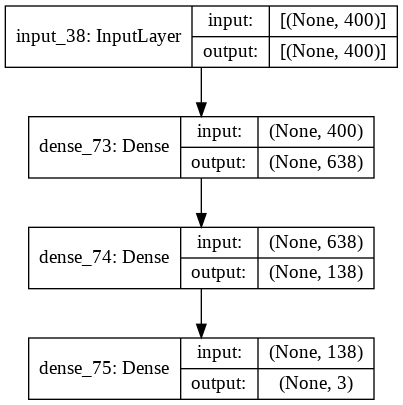

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
loss_fn = losses.CategoricalCrossentropy()
optimizer = optimizers.Adam() # LR 0.001 is the default

In [ ]:
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])

In [ ]:
start = time.process_time()
from tensorflow.keras import callbacks
checkpoint=callbacks.ModelCheckpoint(filepath='FULLModel.h',monitor='val_accuracy',save_best_only=True)
Monitor = model.fit(Xtrain, Ytrain, epochs=300, batch_size=batch, validation_data=(Xtest,Ytest), callbacks=[checkpoint])
model_h_time = (time.process_time() - start)
print(f"Time to run model: {model_h_time//60} minute {model_h_time%60} seconds")

Epoch 1/300
76/76 [==============================] - 1s 9ms/step - loss: 0.7841 - accuracy: 0.6632 - val_loss: 0.5412 - val_accuracy: 0.7878
INFO:tensorflow:Assets written to: FULLModel.h/assets
Epoch 2/300
76/76 [==============================] - 1s 7ms/step - loss: 0.5135 - accuracy: 0.7996 - val_loss: 0.4975 - val_accuracy: 0.7863
Epoch 3/300
76/76 [==============================] - 1s 7ms/step - loss: 0.4482 - accuracy: 0.8283 - val_loss: 0.4471 - val_accuracy: 0.8144
INFO:tensorflow:Assets written to: FULLModel.h/assets
Epoch 4/300
76/76 [==============================] - 1s 7ms/step - loss: 0.4263 - accuracy: 0.8383 - val_loss: 0.4060 - val_accuracy: 0.8360
INFO:tensorflow:Assets written to: FULLModel.h/assets
Epoch 5/300
76/76 [==============================] - 0s 7ms/step - loss: 0.3474 - accuracy: 0.8690 - val_loss: 0.3669 - val_accuracy: 0.8619
INFO:tensorflow:Assets written to: FULLModel.h/assets
Epoch 6/300
76/76 [==============================] - 1s 7ms/step - loss: 0.3116

In [ ]:
def plot_loss_and_acc(train_loss, val_loss, train_acc, val_acc):
  fig = plt.figure(figsize= (15,4))
  ax1 = fig.add_subplot(1,2,1)
  # Train & Test Loss plot
  plt.plot(range(1,(len(train_loss)+1)), train_loss, color='dodgerblue', linewidth=1, markersize=6) # Train Loss
  plt.plot(range(1,(len(train_loss)+1)), val_loss, color='red', linewidth=1, markersize=6) # Test Loss
  plt.xlabel('epoch #')
  plt.ylabel('Cross-Entropy Value')
  plt.title('C.E. Loss Plot')
  plt.legend(['Train Loss', 'Test Loss'])

  ax1 = fig.add_subplot(1,2,2)
  # Train & Test Accuracy plot
  plt.plot(range(1,(len(train_acc)+1)), train_acc, color='dodgerblue', linewidth=1, markersize=6) # Train Loss
  plt.plot(range(1,(len(train_acc)+1)), val_acc, color='red', linewidth=1, markersize=6) # Test Loss
  plt.xlabel('epoch #')
  plt.ylabel('Accuracy Value')
  plt.title('Accuracy Plot')
  plt.legend(['Train Acc', 'Test Acc']);

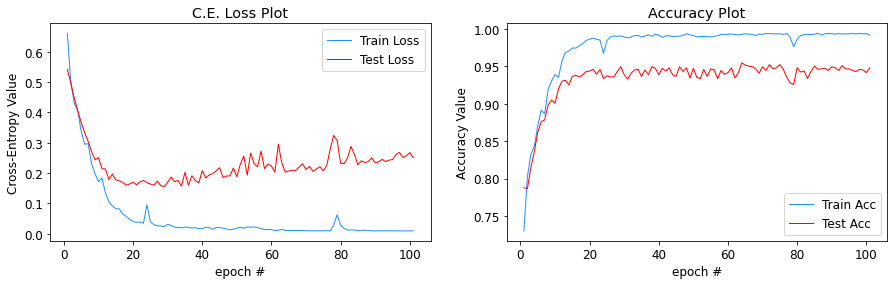

In [ ]:
plot_loss_and_acc(Monitor.history['loss'][:101], Monitor.history['val_loss'][:101],
                  Monitor.history['accuracy'][:101], Monitor.history['val_accuracy'][:101])

In [ ]:
inputs = keras.Input(shape=(400,)) # 400-dimonsional vector and Batch size not specified since it can vary.
x1 = layers.Dense(h_star,activation="sigmoid")(inputs) # Giving this layer the inputs
x2 = layers.Dense(H1_dim,activation="sigmoid")(x1)# Feeding X1 to the spartsity layer
outputs = layers.Dense(3, activation="softmax")(x2) # Output layer with 3 classes

model = keras.Model(inputs=inputs,outputs=outputs)
model.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])

In [ ]:
my_epochs= 22     #Value From Tstop
checkpoint=callbacks.ModelCheckpoint(filepath='FULLModel.h',monitor='val_accuracy',save_best_only=True)
model.fit(Xtrain, Ytrain, epochs=my_epochs, batch_size=batch, validation_data=(Xtest,Ytest), callbacks=[checkpoint])

Epoch 1/22
76/76 [==============================] - 1s 10ms/step - loss: 0.7695 - accuracy: 0.6907 - val_loss: 0.4692 - val_accuracy: 0.8173
INFO:tensorflow:Assets written to: FULLModel.h/assets
Epoch 2/22
76/76 [==============================] - 1s 7ms/step - loss: 0.4024 - accuracy: 0.8423 - val_loss: 0.3723 - val_accuracy: 0.8561
INFO:tensorflow:Assets written to: FULLModel.h/assets
Epoch 3/22
76/76 [==============================] - 1s 7ms/step - loss: 0.3191 - accuracy: 0.8801 - val_loss: 0.3153 - val_accuracy: 0.8827
INFO:tensorflow:Assets written to: FULLModel.h/assets
Epoch 4/22
76/76 [==============================] - 1s 7ms/step - loss: 0.2605 - accuracy: 0.8974 - val_loss: 0.2857 - val_accuracy: 0.8842
INFO:tensorflow:Assets written to: FULLModel.h/assets
Epoch 5/22
76/76 [==============================] - 1s 7ms/step - loss: 0.2170 - accuracy: 0.9195 - val_loss: 0.2388 - val_accuracy: 0.9014
INFO:tensorflow:Assets written to: FULLModel.h/assets
Epoch 6/22
76/76 [===========

In [ ]:
model.evaluate(Xtrain,Ytrain)
y_pred_train = model.predict(Xtrain)
predlabel_train = np.argmax(y_pred_train,axis=1)
Ytrain_true= np.argmax(Ytrain,axis=1)
classes = np.asarray(['1','2','3'])

confusion_matrix(Ytrain_true, predlabel_train)

174/174 [==============================] - 0s 1ms/step - loss: 0.0325 - accuracy: 0.9928


array([[1831,    4,    1],
       [   0, 1827,    1],
       [   0,   34, 1854]])

In [ ]:
model.evaluate(Xtest,Ytest)
y_pred_test = model.predict(Xtest)
predlabel_test = np.argmax(y_pred_test,axis=1)
Ytest_true= np.argmax(Ytest,axis=1)
classes = np.asarray(['1','2','3'])

44/44 [==============================] - 0s 2ms/step - loss: 0.1751 - accuracy: 0.9489


Normalized confusion matrix
[[99.01960784  0.98039216  0.        ]
 [ 0.43763676 99.39824945  0.16411379]
 [ 0.21186441  2.11864407 97.66949153]]


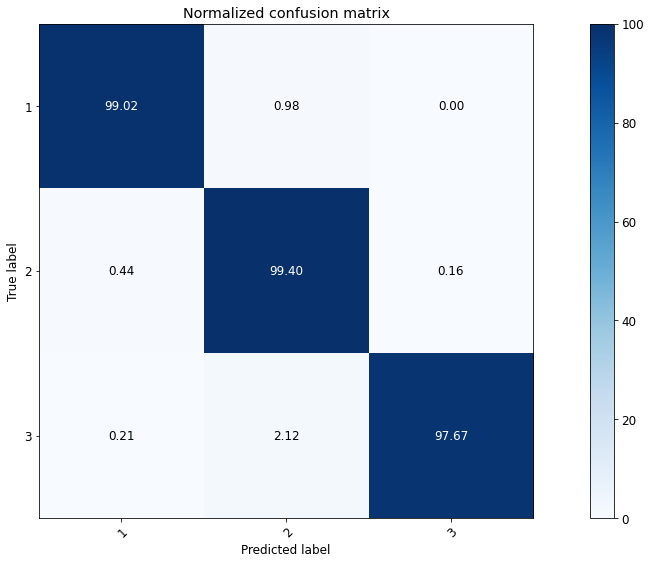

In [ ]:
plot_confusion_matrix(Ytrain_true, predlabel_train, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

0.9489208633093525
Normalized confusion matrix
[[92.60869565  6.52173913  0.86956522]
 [ 1.31291028 96.49890591  2.18818381]
 [ 0.          4.4397463  95.5602537 ]]


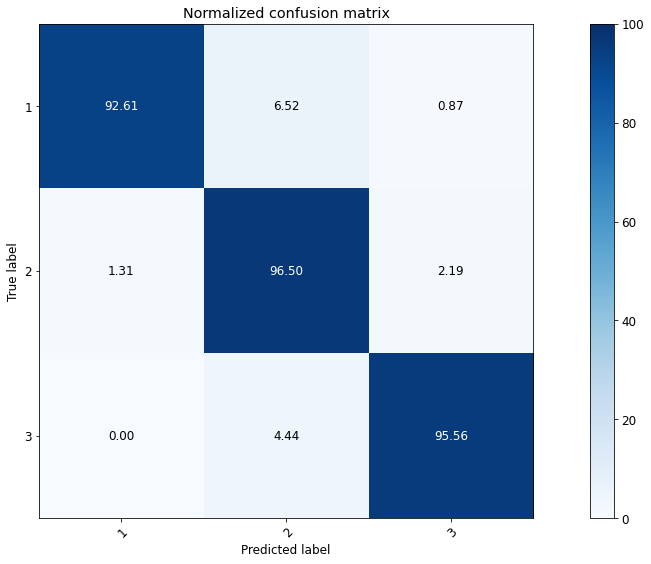

In [ ]:
print(accuracy_score(Ytest_true, predlabel_test))
plot_confusion_matrix(Ytest_true, predlabel_test, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()